## Provide list of paths for edits and run trials -> (maybe analyze results and add to CSV)

In [3]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
from datetime import datetime
import pandas as pd

In [4]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, informal_log, list_to_dict, write_lists, write_json
from utils.model_utils import prepare_device
from parse_config import ConfigParser
# from data_loader import data_loaders
import datasets.datasets as module_data
import model.model as module_arch
from utils.knn_utils import load_and_analyze_knn
from utils.results_to_csv import combine_results
from edit_knn import main as edit

In [3]:
# Obtain timestamp
timestamp = datetime.now().strftime(r'%m%d_%H%M%S')
# timestamp = '0120_155829'

In [4]:
# Define constants, paths
config_path = 'configs/copies/cinic10_imagenet_segmentation_edit_trials.json'
class_list_path = 'metadata/cinic-10/class_names.txt'
# key_image_id = 'dog-train-n02114712_211'
target_class_name = 'cat'

analyze_in_edit = True
# paths_dir = os.path.join('paths', 'edits', key_image_id)
# paths_dir = os.path.join('paths', 'edits', target_class_name, '0113_120339')
paths_dir = os.path.join('paths', 'edits', 'semantics', target_class_name, '0125_112421')

# key_image_paths = read_lists(os.path.join(paths_dir, 'key_images.txt'))
# value_image_paths = read_lists(os.path.join(paths_dir, 'value_images.txt'))
sort_type = 'softmax'
key_image_paths = read_lists(os.path.join(paths_dir, 'key_images_{}.txt'.format(sort_type)))
value_image_paths = read_lists(os.path.join(paths_dir, 'value_images_{}.txt'.format(sort_type)))
n_trials = len(value_image_paths)
assert len(key_image_paths) == n_trials

print("{} edit image pairs".format(n_trials))
print("First key image path: {}".format(key_image_paths[0]))
print("First value image path: {}".format(value_image_paths[0]))

67 edit image pairs
First key image path: data/cinic-10-imagenet/train/cat/n02123159_5240.png
First value image path: saved/segmentations/semantics/cat_50/cat-train-n02123159_5240/felzenszwalb_masked/felzenszwalb_masked_softmax.png


In [5]:
# Load config file
config_dict = read_json(config_path)
# Load class list and obtain target class idx
class_list = read_lists(class_list_path)
class_idx_dict = list_to_dict(class_list)
target_class_idx = class_idx_dict[target_class_name]

# Set K
K = config_dict['editor']['K']

device, device_ids = prepare_device(config_dict['n_gpu'])

In [6]:
# Load datasets
data_loader_args = dict(config_dict["data_loader"]["args"])
dataset_args = dict(config_dict["dataset_args"])

# Create validation data loader
val_image_paths = read_lists(config_dict['dataset_paths']['valid_images'])
val_labels = read_lists(config_dict['dataset_paths']['valid_labels'])
val_paths_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=val_image_paths,
        labels=val_labels,
        return_paths=True,
        **dataset_args
    ),
    **data_loader_args
)

# Create data loader for covariance matrix
covariance_image_paths = read_lists(config_dict['covariance_dataset']['images'])
covariance_labels = read_lists(config_dict['covariance_dataset']['labels'])

covariance_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=covariance_image_paths,
        labels=covariance_labels,
        **dataset_args
    ),
    **data_loader_args
)

### Create log and save paths

In [7]:
# create log path to store the paths to each trial
save_root = config_dict['trainer']['save_dir']
save_trials_path = os.path.join(save_root, config_dict['name'], timestamp, 'trial_paths.txt')
progress_report_path = os.path.join(save_root, config_dict['name'], timestamp, 'progress_report.txt')
if os.path.exists(save_trials_path):
    # os.remove(save_trials_path)
    print("Path {} already exists. Aborting.".format(save_trials_path))
else:
    # progress_report_path = os.path.join(save_root, config_dict['name'], timestamp, 'progress_report.txt')
    if os.path.exists(progress_report_path):
        os.remove(progress_report_path)
    print("Saving path to directories for each trial to {}".format(save_trials_path))
    print("Printing progress reports to {}".format(progress_report_path))

Saving path to directories for each trial to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/trial_paths.txt
Printing progress reports to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/progress_report.txt


### Ensure all paths for keys and values exist

In [8]:
non_existent_key_paths = []
non_existent_value_paths = []
for key_path, value_path in zip(key_image_paths, value_image_paths):
    if not os.path.exists(key_path):
        non_existent_key_paths.append(key_path)
    if not os.path.exists(value_path):
        non_existent_value_paths.append(value_path)

if len(non_existent_key_paths) > 0:
    raise ValueError("Following paths are non existent: {}".format(non_existent_key_paths))
    
if len(non_existent_value_paths) > 0:
    raise ValueError("Following paths are non existent: {}".format(non_existent_value_paths))
    

## Run edit for each modified image

(0125_114456) Starting Trial 1/67...
Current run_id: 0125_114341/results/cat-train-n02123159_5240/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02123159_5240/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/cat/n02123159_5240.png
Value images: saved/segmentations/semantics/cat_50/cat-train-n02123159_5240/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Performing pre-edit metric & KNN calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [01:00<00:00,  4.51it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:55<00:00, 725.00it/s]

Loss (orig, final): 0.12392816692590714 0.004878872074186802
L2 norm of weight change: 0.32009774446487427
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.98it/s]


Post-edit metrics: {'TP': array([6152, 5269, 5085, 4954, 2554, 2908, 5514, 5029, 4718, 4870]), 'TN': array([60090, 61289, 59756, 55550, 62522, 61815, 61400, 61917, 61807,
       60907]), 'FPs': array([2910, 1711, 3244, 7450,  478, 1185, 1600, 1083, 1193, 2093]), 'FNs': array([ 848, 1731, 1915, 2046, 4446, 4092, 1486, 1971, 2282, 2130]), 'accuracy': 0.6721857142857143, 'per_class_accuracy': array([0.94631429, 0.95082857, 0.9263    , 0.86434286, 0.92965714,
       0.92461429, 0.95591429, 0.95637143, 0.95035714, 0.93967143]), 'per_class_accuracy_mean': 0.9344371428571427, 'precision': array([0.67887883, 0.75487106, 0.61051747, 0.39938729, 0.84234828,
       0.71048131, 0.77509137, 0.82280759, 0.7981729 , 0.69941117]), 'precision_mean': 0.7091967284970597, 'recall': array([0.87885714, 0.75271429, 0.72642857, 0.70771429, 0.36485714,
       0.41542857, 0.78771429, 0.71842857, 0.674     , 0.69571429]), 'recall_mean': 0.6721857142857143, 'predicted_class_distribution': array([ 9062,  6980,  83

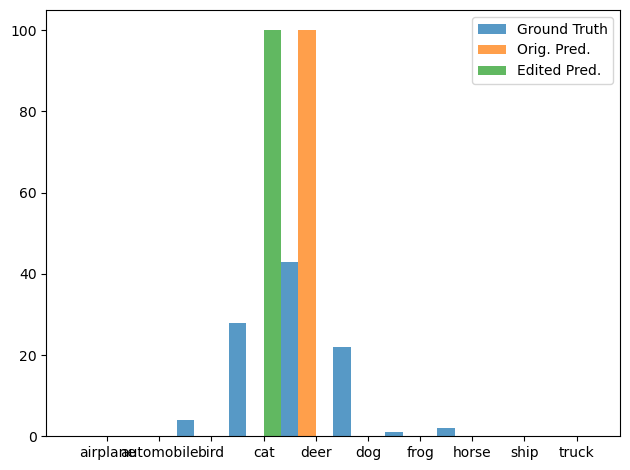

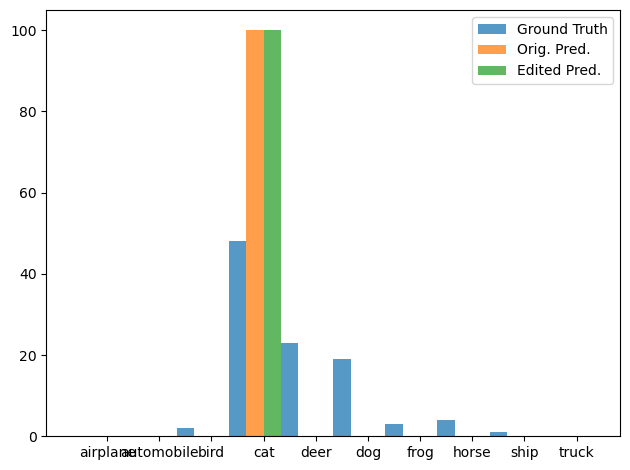

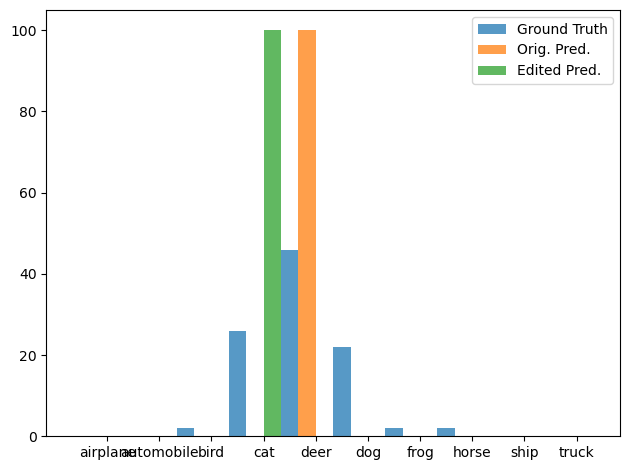

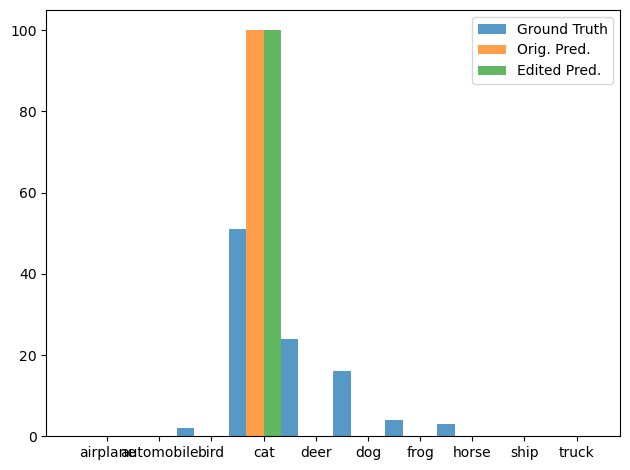

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02123159_5240/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02123159_5240/felzenszwalb_masked_softmax/models
Finished trial 1/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02123159_5240/felzenszwalb_masked_softmax
(0125_114728) Starting Trial 2/67...
Current run_id: 0125_114341/results/cat-train-n02123159_5240/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02123159_5240/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-ima

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.23it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0257, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:48<00:00, 825.28it/s]

Loss (orig, final): 0.15887457132339478 0.025719167664647102
L2 norm of weight change: 0.4898461401462555
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.34it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6169, 5303, 5203, 4561,    0, 2874, 5688, 5048, 4520, 5006]), 'TN': array([60085, 61172, 59293, 57347, 63000, 61926, 60835, 61807, 62017,
       56890]), 'FPs': array([2915, 1828, 3707, 5653,    0, 1074, 2165, 1193,  983, 6110]), 'FNs': array([ 831, 1697, 1797, 2439, 7000, 4126, 1312, 1952, 2480, 1994]), 'accuracy': 0.6338857142857143, 'per_class_accuracy': array([0.94648571, 0.94964286, 0.92137143, 0.8844    , 0.9       ,
       0.92571429, 0.95032857, 0.95507143, 0.95052857, 0.88422857]), 'per_class_accuracy_mean': 0.9267771428571429, 'precision': array([0.67910612, 0.74365447, 0.58395062, 0.44654396, 0.        ,
       0.72796353, 0.72430918, 0.80884474, 0.82137016, 0.45034185]), 'precision_mean': 0.5986084618398575, 'recall': array([0.88128571, 0.75757143, 0.74328571, 0.65157143, 0.        ,
       0.41057143, 0.81257143, 0.72114286, 0.64571429, 0.71514286]), 'recall_mean': 0.6338857142857143, 'predicted_class_distribution': array([ 9084,  7131,  89

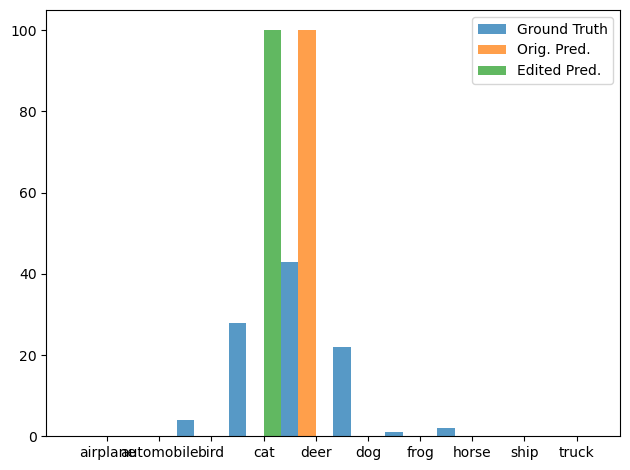

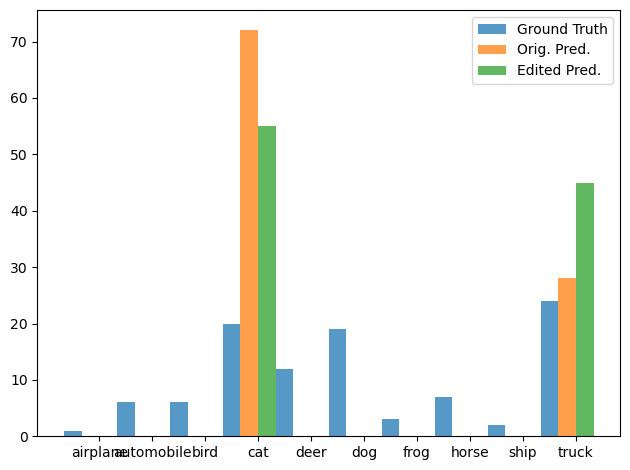

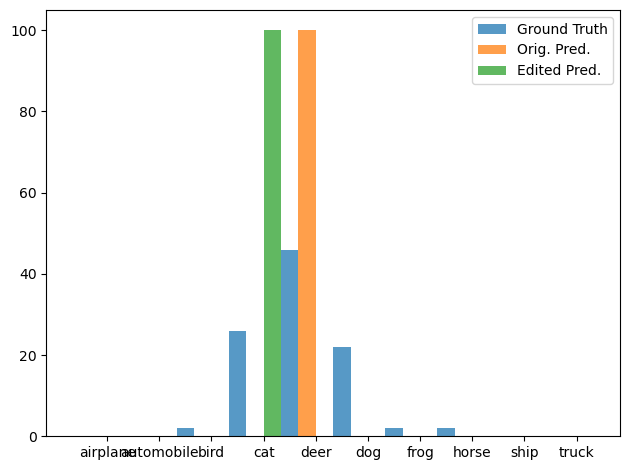

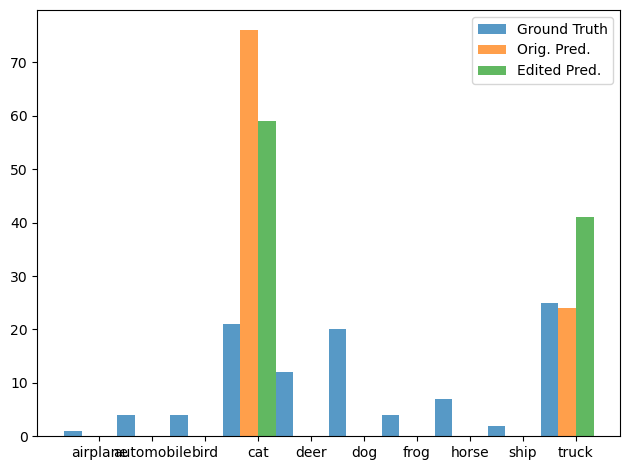

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02123159_5240/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02123159_5240/felzenszwalb_gaussian_softmax/models
Finished trial 2/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02123159_5240/felzenszwalb_gaussian_softmax
(0125_114837) Starting Trial 3/67...
Current run_id: 0125_114341/results/cat-train-n02129837_1765/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129837_1765/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-i

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:04<00:00, 55.05it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 884.64it/s]

Loss (orig, final): 0.1691950559616089 0.0045477245002985
L2 norm of weight change: 0.6107685565948486
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.82it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6198, 5109, 4837, 5965,    0, 2777, 3449, 4787, 4547, 4889]), 'TN': array([60023, 61522, 60507, 47446, 63000, 61908, 62882, 62204, 62019,
       61047]), 'FPs': array([ 2977,  1478,  2493, 15554,     0,  1092,   118,   796,   981,
        1953]), 'FNs': array([ 802, 1891, 2163, 1035, 7000, 4223, 3551, 2213, 2453, 2111]), 'accuracy': 0.6079714285714286, 'per_class_accuracy': array([0.94601429, 0.95187143, 0.93348571, 0.76301429, 0.9       ,
       0.92407143, 0.94758571, 0.95701429, 0.95094286, 0.94194286]), 'per_class_accuracy_mean': 0.9215942857142856, 'precision': array([0.67553134, 0.77561864, 0.65989086, 0.2771969 , 0.        ,
       0.71775653, 0.96691898, 0.85742432, 0.8225398 , 0.71455715]), 'precision_mean': 0.6467434507216346, 'recall': array([0.88542857, 0.72985714, 0.691     , 0.85214286, 0.        ,
       0.39671429, 0.49271429, 0.68385714, 0.64957143, 0.69842857]), 'recall_mean': 0.6079714285714287, 'predicted_class_distribution': array([

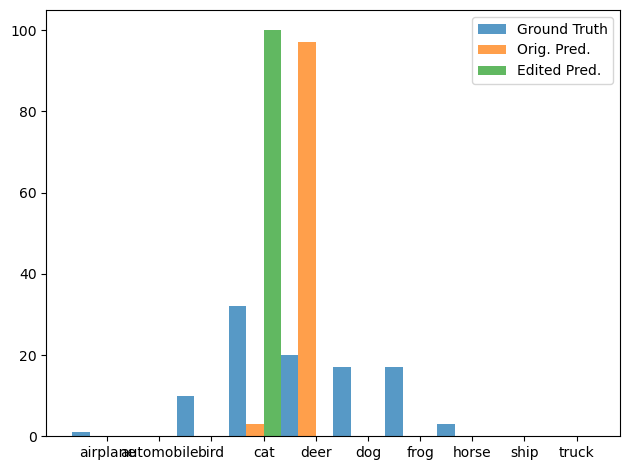

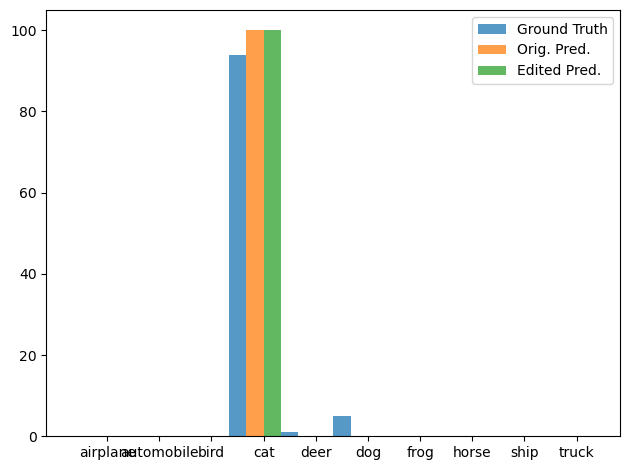

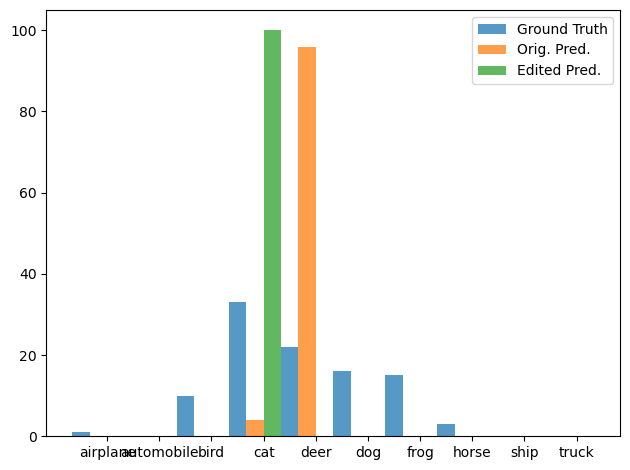

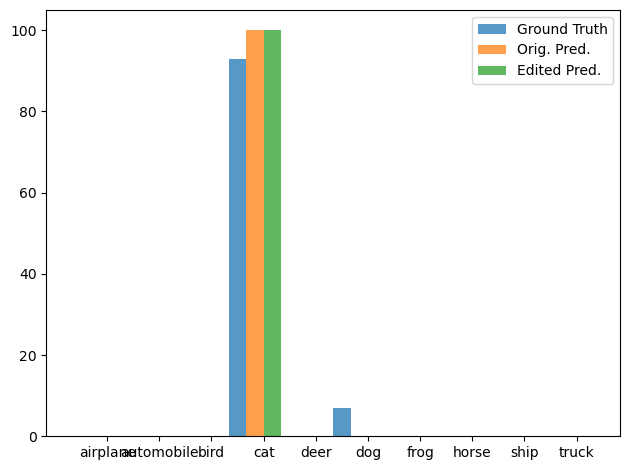

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129837_1765/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129837_1765/felzenszwalb_masked_softmax/models
Finished trial 3/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129837_1765/felzenszwalb_masked_softmax
(0125_114940) Starting Trial 4/67...
Current run_id: 0125_114341/results/cat-train-n02129923_8962/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129923_8962/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagene

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:04<00:00, 56.03it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 871.53it/s]

Loss (orig, final): 0.128401517868042 0.005824838764965534
L2 norm of weight change: 0.4698966443538666
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.17it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6194, 5249, 5050, 5260,    0, 2849, 5432, 4787, 4639, 4840]), 'TN': array([59966, 61312, 59859, 51636, 63000, 61834, 61553, 62207, 61919,
       61014]), 'FPs': array([ 3034,  1688,  3141, 11364,     0,  1166,  1447,   793,  1081,
        1986]), 'FNs': array([ 806, 1751, 1950, 1740, 7000, 4151, 1568, 2213, 2361, 2160]), 'accuracy': 0.6328571428571429, 'per_class_accuracy': array([0.94514286, 0.95087143, 0.92727143, 0.8128    , 0.9       ,
       0.92404286, 0.95692857, 0.95705714, 0.95082857, 0.94077143]), 'per_class_accuracy_mean': 0.9265714285714285, 'precision': array([0.67121803, 0.75666715, 0.61653034, 0.31641001, 0.        ,
       0.70958904, 0.78964966, 0.8578853 , 0.81101399, 0.70905362]), 'precision_mean': 0.623801713572614, 'recall': array([0.88485714, 0.74985714, 0.72142857, 0.75142857, 0.        ,
       0.407     , 0.776     , 0.68385714, 0.66271429, 0.69142857]), 'recall_mean': 0.6328571428571428, 'predicted_class_distribution': array([ 

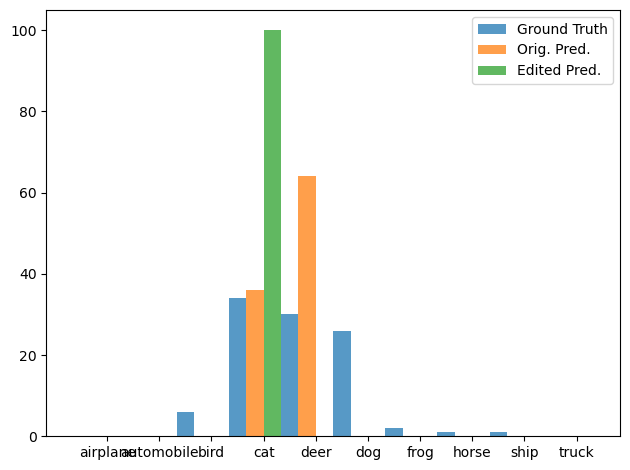

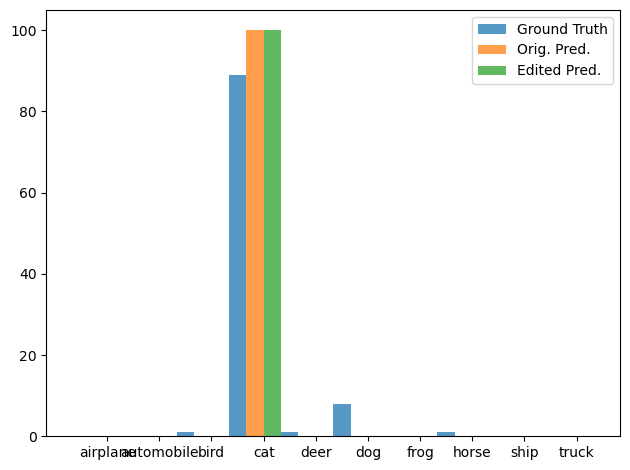

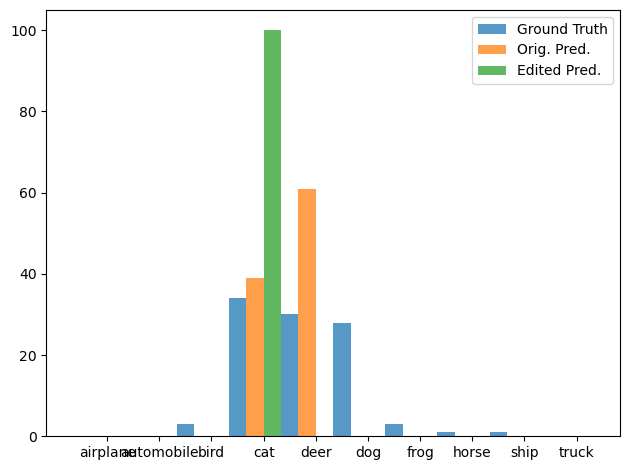

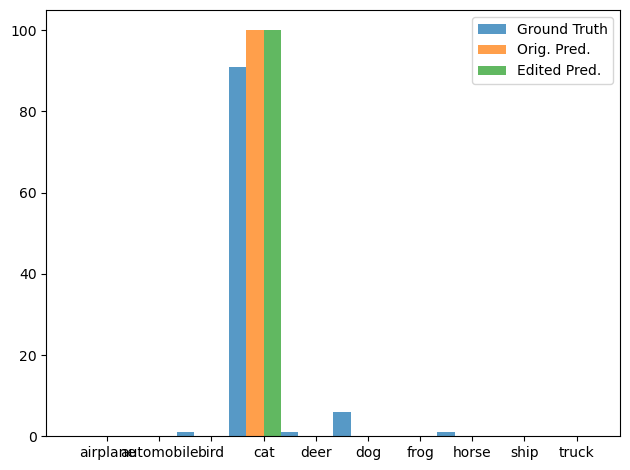

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129923_8962/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129923_8962/felzenszwalb_masked_softmax/models
Finished trial 4/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129923_8962/felzenszwalb_masked_softmax
(0125_115043) Starting Trial 5/67...
Current run_id: 0125_114341/results/cat-train-n02129923_8962/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129923_8962/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-ima

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:04<00:00, 54.85it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 877.74it/s]

Loss (orig, final): 0.027049340307712555 0.0026982889976352453
L2 norm of weight change: 0.1201181709766388
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.21it/s]


Post-edit metrics: {'TP': array([6148, 5354, 5144, 4109, 4121, 2993, 5652, 5030, 4848, 4679]), 'TN': array([60043, 61170, 59604, 59151, 60444, 61762, 61089, 61942, 61617,
       61256]), 'FPs': array([2957, 1830, 3396, 3849, 2556, 1238, 1911, 1058, 1383, 1744]), 'FNs': array([ 852, 1646, 1856, 2891, 2879, 4007, 1348, 1970, 2152, 2321]), 'accuracy': 0.6868285714285715, 'per_class_accuracy': array([0.94558571, 0.95034286, 0.92497143, 0.90371429, 0.92235714,
       0.92507143, 0.95344286, 0.95674286, 0.9495    , 0.94192857]), 'per_class_accuracy_mean': 0.9373657142857142, 'precision': array([0.67523339, 0.74526726, 0.60234192, 0.51633576, 0.61719335,
       0.70739778, 0.74732249, 0.82621551, 0.77804526, 0.72847579]), 'precision_mean': 0.6943828505266991, 'recall': array([0.87828571, 0.76485714, 0.73485714, 0.587     , 0.58871429,
       0.42757143, 0.80742857, 0.71857143, 0.69257143, 0.66842857]), 'recall_mean': 0.6868285714285715, 'predicted_class_distribution': array([9105, 7184, 8540,

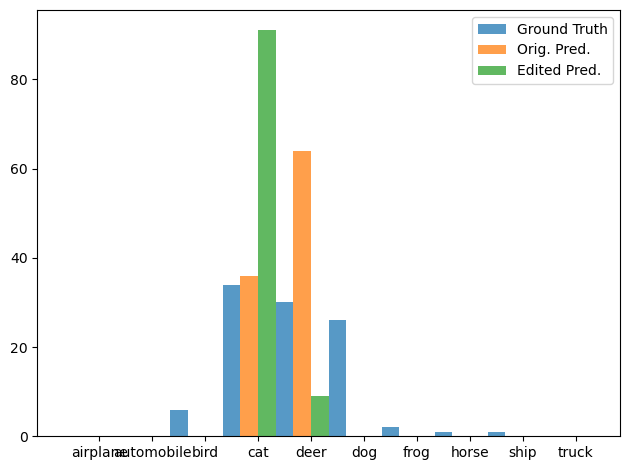

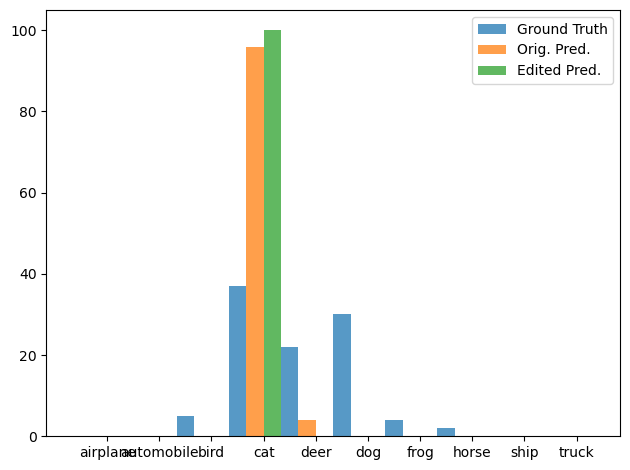

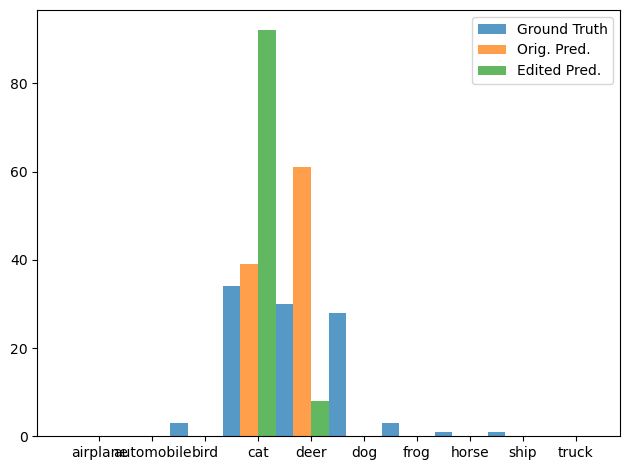

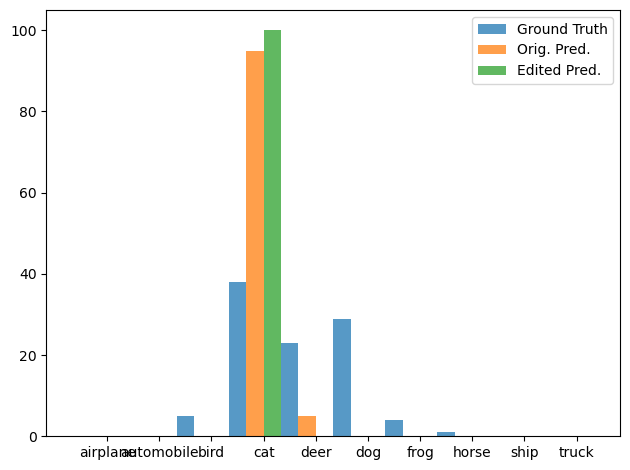

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129923_8962/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129923_8962/felzenszwalb_gaussian_softmax/models
Finished trial 5/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129923_8962/felzenszwalb_gaussian_softmax
(0125_115148) Starting Trial 6/67...
Current run_id: 0125_114341/results/cat-train-n01322898_3222/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n01322898_3222/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-i

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.74it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 875.13it/s]

Loss (orig, final): 0.11718752980232239 0.0035197692923247814
L2 norm of weight change: 0.4864170551300049
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 22.91it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6186, 4943, 5193, 4882, 4013, 2967, 4954, 4750, 4543,    0]), 'TN': array([59865, 61664, 59391, 50121, 60668, 61296, 62240, 62245, 61941,
       63000]), 'FPs': array([ 3135,  1336,  3609, 12879,  2332,  1704,   760,   755,  1059,
           0]), 'FNs': array([ 814, 2057, 1807, 2118, 2987, 4033, 2046, 2250, 2457, 7000]), 'accuracy': 0.6061571428571428, 'per_class_accuracy': array([0.94358571, 0.95152857, 0.92262857, 0.78575714, 0.92401429,
       0.91804286, 0.95991429, 0.95707143, 0.94977143, 0.9       ]), 'per_class_accuracy_mean': 0.9212314285714287, 'precision': array([0.6636627 , 0.78722727, 0.58997955, 0.27487191, 0.63246651,
       0.63519589, 0.86699335, 0.86285195, 0.81096037, 0.        ]), 'precision_mean': 0.6124209495418353, 'recall': array([0.88371429, 0.70614286, 0.74185714, 0.69742857, 0.57328571,
       0.42385714, 0.70771429, 0.67857143, 0.649     , 0.        ]), 'recall_mean': 0.6061571428571428, 'predicted_class_distribution': array([

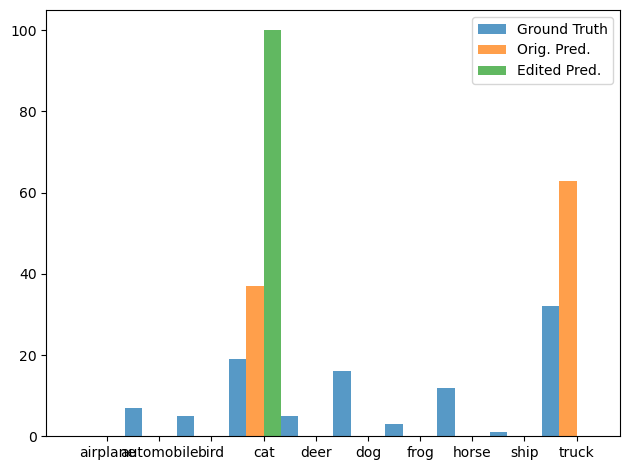

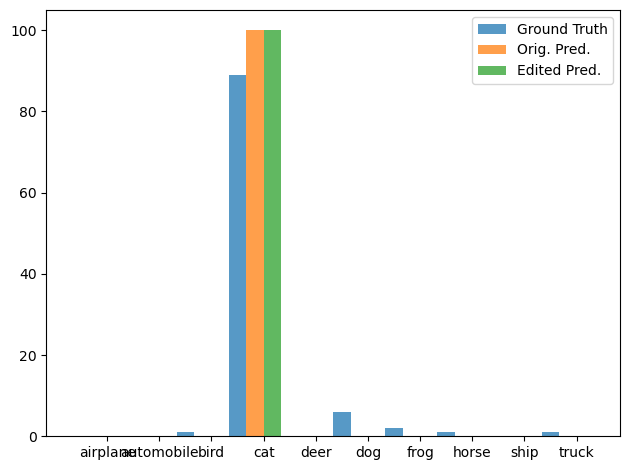

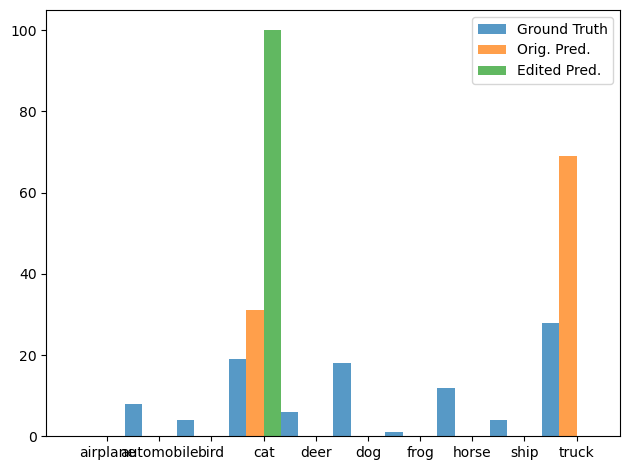

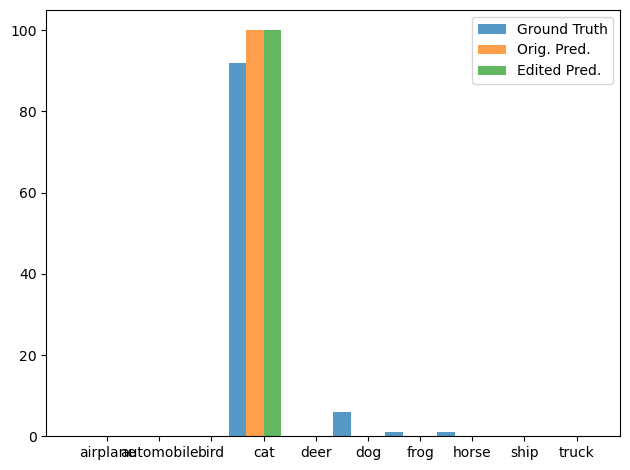

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n01322898_3222/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n01322898_3222/felzenszwalb_masked_softmax/models
Finished trial 6/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n01322898_3222/felzenszwalb_masked_softmax
(0125_115258) Starting Trial 7/67...
Current run_id: 0125_114341/results/cat-train-n01322898_3222/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n01322898_3222/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-ima

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.85it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 884.89it/s]

Loss (orig, final): 0.11015743017196655 0.00686014536768198
L2 norm of weight change: 0.41667404770851135
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 18.75it/s]


Post-edit metrics: {'TP': array([6183, 5219, 5463, 4114, 4327, 3078, 5272, 4734, 4672,  171]), 'TN': array([59671, 61354, 58145, 54066, 59937, 61430, 61802, 62240, 61666,
       62922]), 'FPs': array([3329, 1646, 4855, 8934, 3063, 1570, 1198,  760, 1334,   78]), 'FNs': array([ 817, 1781, 1537, 2886, 2673, 3922, 1728, 2266, 2328, 6829]), 'accuracy': 0.6176142857142857, 'per_class_accuracy': array([0.94077143, 0.95104286, 0.90868571, 0.83114286, 0.91805714,
       0.92154286, 0.9582    , 0.95677143, 0.94768571, 0.90132857]), 'per_class_accuracy_mean': 0.9235228571428571, 'precision': array([0.65002103, 0.76023307, 0.52946307, 0.31529736, 0.58552097,
       0.66222031, 0.81483771, 0.86166727, 0.77788878, 0.68674699]), 'precision_mean': 0.664389656601968, 'recall': array([0.88328571, 0.74557143, 0.78042857, 0.58771429, 0.61814286,
       0.43971429, 0.75314286, 0.67628571, 0.66742857, 0.02442857]), 'recall_mean': 0.6176142857142858, 'predicted_class_distribution': array([ 9512,  6865, 1031

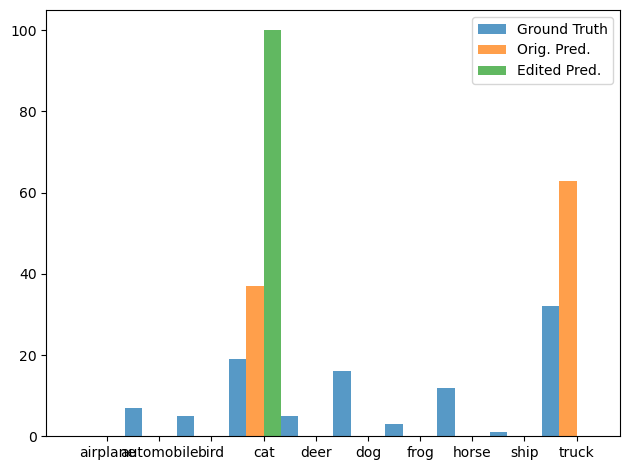

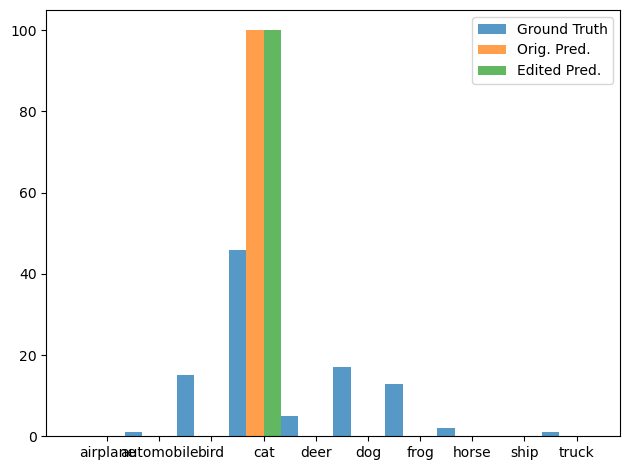

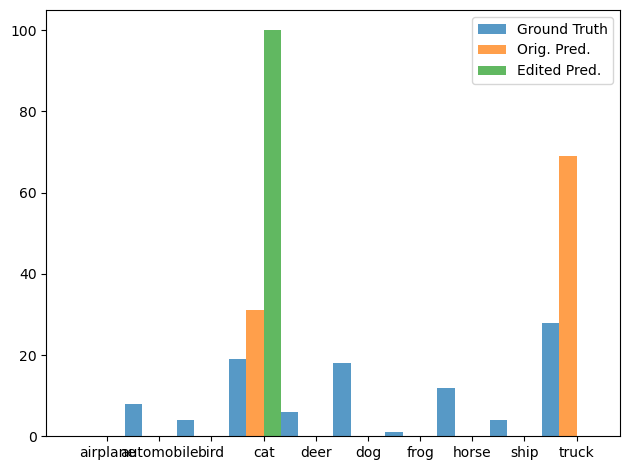

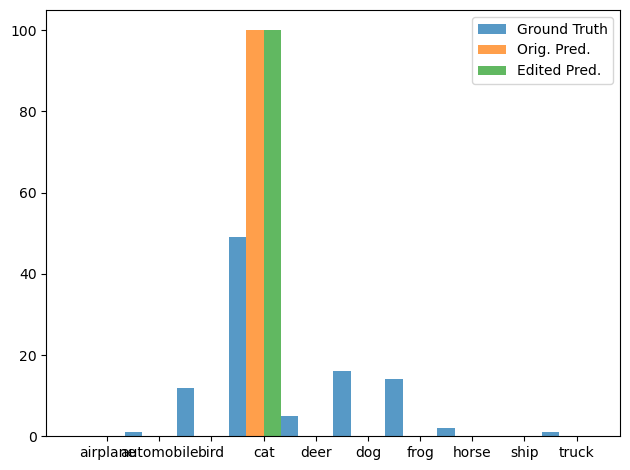

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n01322898_3222/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n01322898_3222/felzenszwalb_gaussian_softmax/models
Finished trial 7/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n01322898_3222/felzenszwalb_gaussian_softmax
(0125_115410) Starting Trial 8/67...
Current run_id: 0125_114341/results/cat-train-n02124484_5856/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02124484_5856/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-i

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:04<00:00, 56.37it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 877.21it/s]

Loss (orig, final): 0.052580319344997406 0.0033347024582326412
L2 norm of weight change: 0.2955267131328583
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.28it/s]


Post-edit metrics: {'TP': array([6108, 5203, 4862, 4616, 4083, 2891, 5646, 4677, 4960, 4745]), 'TN': array([60298, 61404, 60425, 57179, 60605, 61759, 61086, 62288, 61488,
       61259]), 'FPs': array([2702, 1596, 2575, 5821, 2395, 1241, 1914,  712, 1512, 1741]), 'FNs': array([ 892, 1797, 2138, 2384, 2917, 4109, 1354, 2323, 2040, 2255]), 'accuracy': 0.6827285714285715, 'per_class_accuracy': array([0.94865714, 0.95152857, 0.93267143, 0.88278571, 0.92411429,
       0.92357143, 0.95331429, 0.95664286, 0.94925714, 0.94291429]), 'per_class_accuracy_mean': 0.9365457142857142, 'precision': array([0.69330306, 0.7652596 , 0.65375824, 0.44227268, 0.63028713,
       0.69966118, 0.7468254 , 0.86787901, 0.76637824, 0.7315757 ]), 'precision_mean': 0.6997200243836936, 'recall': array([0.87257143, 0.74328571, 0.69457143, 0.65942857, 0.58328571,
       0.413     , 0.80657143, 0.66814286, 0.70857143, 0.67785714]), 'recall_mean': 0.6827285714285714, 'predicted_class_distribution': array([ 8810,  6799,  74

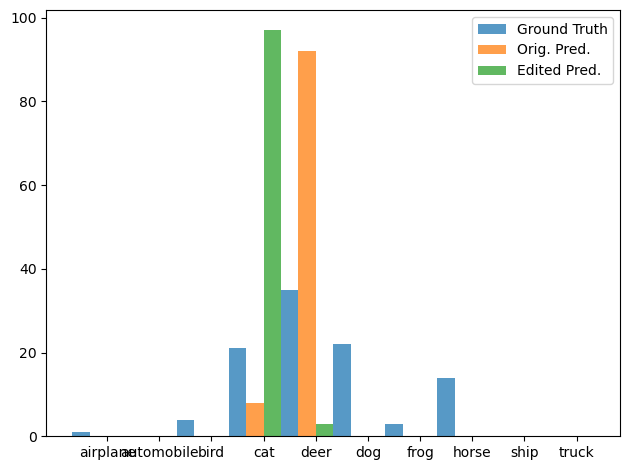

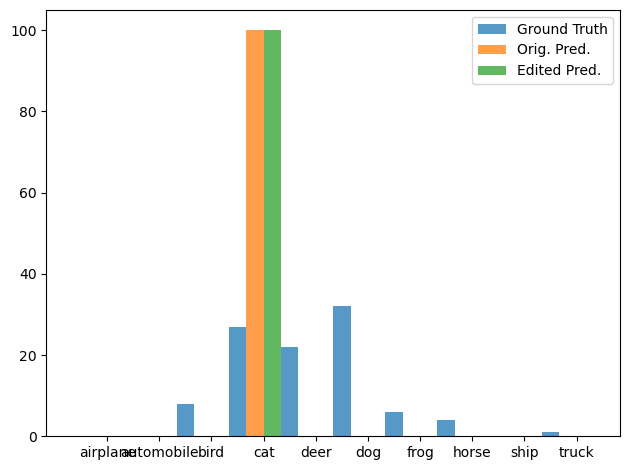

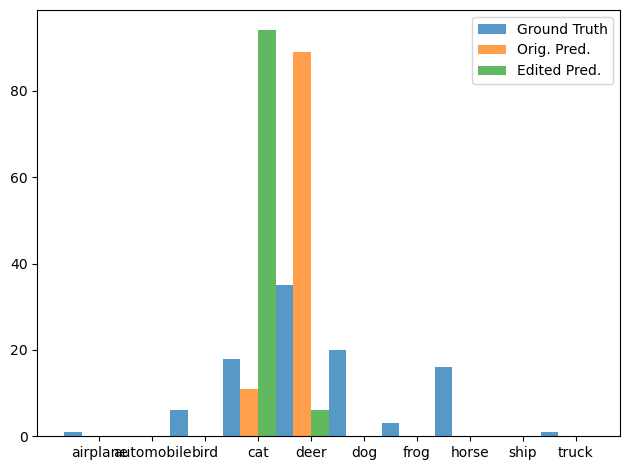

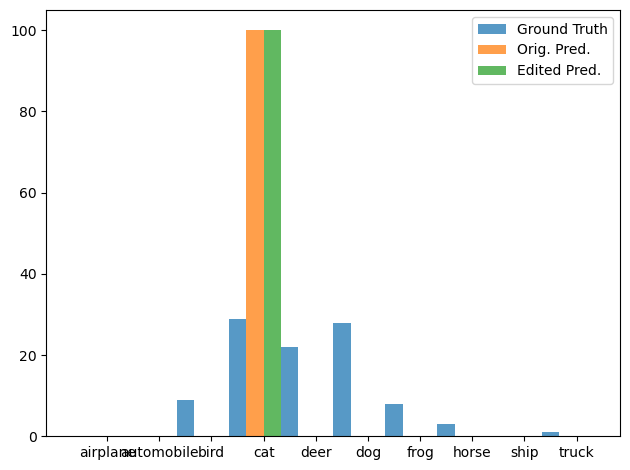

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02124484_5856/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02124484_5856/felzenszwalb_masked_softmax/models
Finished trial 8/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02124484_5856/felzenszwalb_masked_softmax
(0125_115514) Starting Trial 9/67...
Current run_id: 0125_114341/results/cat-train-n02124484_5856/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02124484_5856/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-ima

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:04<00:00, 58.14it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 876.66it/s]

Loss (orig, final): 0.0511125773191452 0.003918068949133158
L2 norm of weight change: 0.20400893688201904
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.22it/s]


Post-edit metrics: {'TP': array([6168, 5240, 5258, 4215, 3768, 2749, 5686, 5190, 4643, 4956]), 'TN': array([60044, 61329, 59258, 58873, 61146, 62065, 60958, 61626, 61894,
       60680]), 'FPs': array([2956, 1671, 3742, 4127, 1854,  935, 2042, 1374, 1106, 2320]), 'FNs': array([ 832, 1760, 1742, 2785, 3232, 4251, 1314, 1810, 2357, 2044]), 'accuracy': 0.6839, 'per_class_accuracy': array([0.94588571, 0.95098571, 0.92165714, 0.90125714, 0.92734286,
       0.92591429, 0.95205714, 0.95451429, 0.95052857, 0.93765714]), 'per_class_accuracy_mean': 0.9367800000000001, 'precision': array([0.67601929, 0.75821155, 0.58422222, 0.50527451, 0.67022412,
       0.74619978, 0.73576605, 0.79067642, 0.80761872, 0.68114349]), 'precision_mean': 0.6955356139794613, 'recall': array([0.88114286, 0.74857143, 0.75114286, 0.60214286, 0.53828571,
       0.39271429, 0.81228571, 0.74142857, 0.66328571, 0.708     ]), 'recall_mean': 0.6839, 'predicted_class_distribution': array([9124, 6911, 9000, 8342, 5622, 3684, 7728,

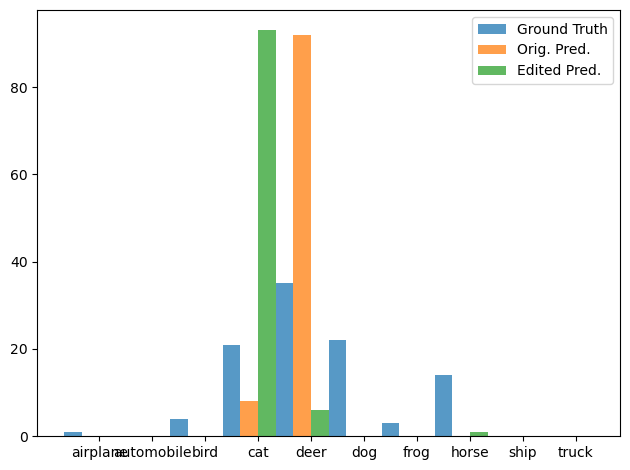

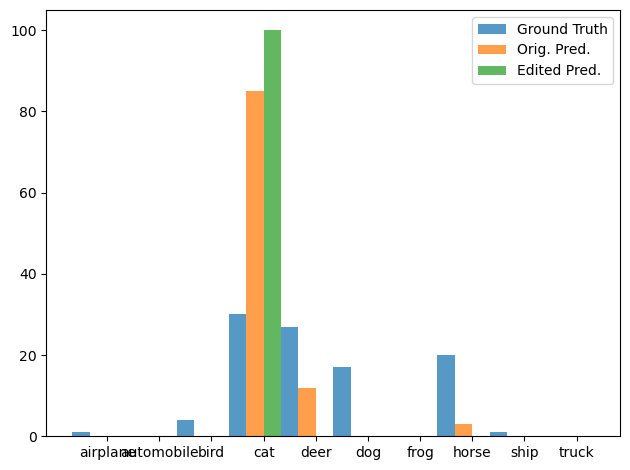

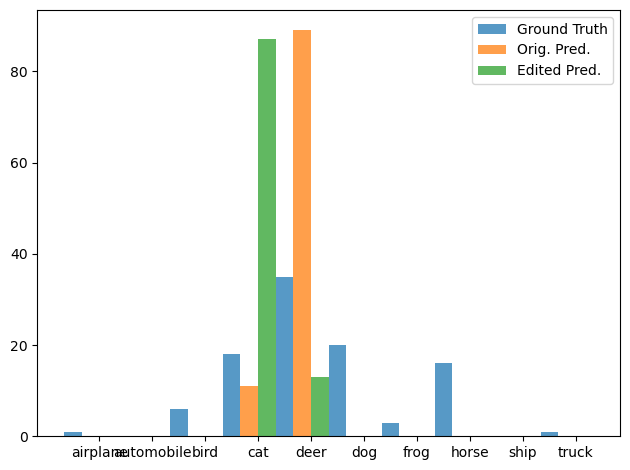

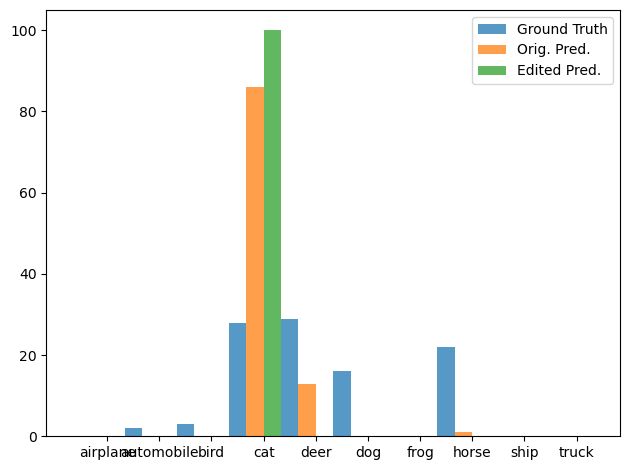

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02124484_5856/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02124484_5856/felzenszwalb_gaussian_softmax/models
Finished trial 9/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02124484_5856/felzenszwalb_gaussian_softmax
(0125_115617) Starting Trial 10/67...
Current run_id: 0125_114341/results/cat-train-n02129463_466/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129463_466/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-im

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:04<00:00, 60.07it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 877.00it/s]

Loss (orig, final): 0.18368685245513916 0.00688721751794219
L2 norm of weight change: 0.7096465229988098
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.81it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6277, 4986, 4757, 5828,    0, 2332, 5110, 4310, 4230, 5071]), 'TN': array([59625, 61651, 60657, 47980, 63000, 62414, 62140, 62526, 62298,
       60610]), 'FPs': array([ 3375,  1349,  2343, 15020,     0,   586,   860,   474,   702,
        2390]), 'FNs': array([ 723, 2014, 2243, 1172, 7000, 4668, 1890, 2690, 2770, 1929]), 'accuracy': 0.6128714285714286, 'per_class_accuracy': array([0.94145714, 0.95195714, 0.93448571, 0.76868571, 0.9       ,
       0.92494286, 0.96071429, 0.9548    , 0.9504    , 0.9383    ]), 'per_class_accuracy_mean': 0.9225742857142857, 'precision': array([0.65033154, 0.78705604, 0.67      , 0.2795472 , 0.        ,
       0.79917752, 0.8559464 , 0.90091973, 0.85766423, 0.6796676 ]), 'precision_mean': 0.6480310262567321, 'recall': array([0.89671429, 0.71228571, 0.67957143, 0.83257143, 0.        ,
       0.33314286, 0.73      , 0.61571429, 0.60428571, 0.72442857]), 'recall_mean': 0.6128714285714285, 'predicted_class_distribution': array([

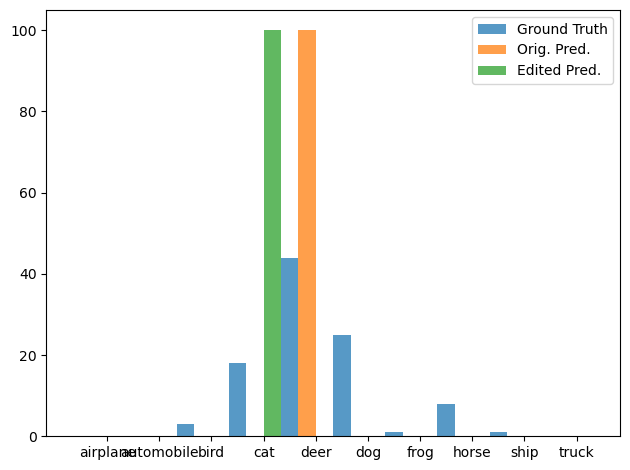

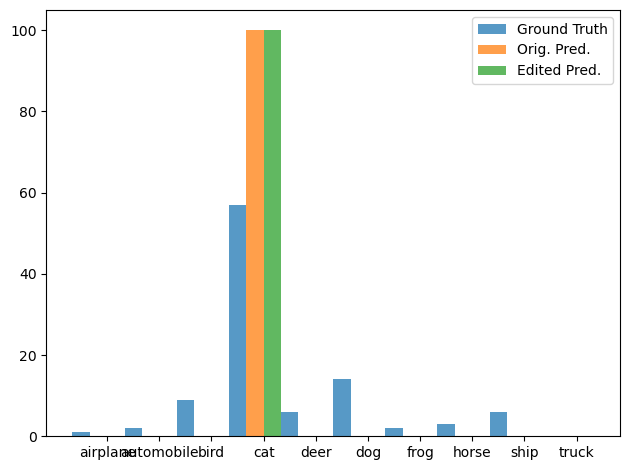

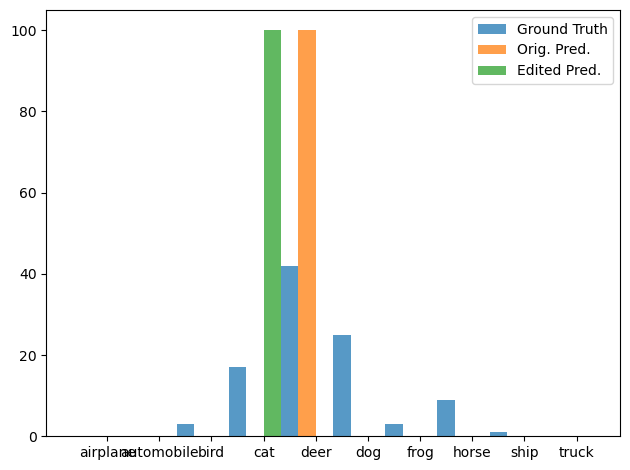

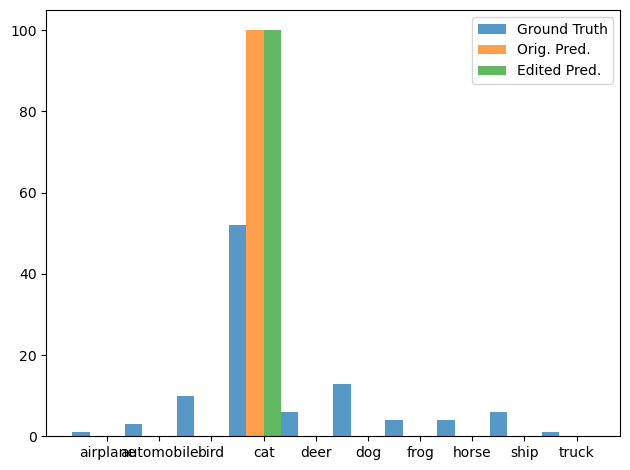

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129463_466/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129463_466/felzenszwalb_masked_softmax/models
Finished trial 10/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129463_466/felzenszwalb_masked_softmax
(0125_115720) Starting Trial 11/67...
Current run_id: 0125_114341/results/cat-train-n02127052_20412/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02127052_20412/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagen

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:04<00:00, 58.42it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0214, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 873.85it/s]

Loss (orig, final): 0.1517353653907776 0.021420907229185104
L2 norm of weight change: 0.3993501365184784
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.15it/s]


Post-edit metrics: {'TP': array([6268, 5294, 5323, 4640, 3189, 3016, 4845, 5109, 4846, 4708]), 'TN': array([58979, 61227, 58800, 57867, 61954, 61743, 62364, 61786, 61397,
       61121]), 'FPs': array([4021, 1773, 4200, 5133, 1046, 1257,  636, 1214, 1603, 1879]), 'FNs': array([ 732, 1706, 1677, 2360, 3811, 3984, 2155, 1891, 2154, 2292]), 'accuracy': 0.6748285714285714, 'per_class_accuracy': array([0.9321    , 0.9503    , 0.91604286, 0.89295714, 0.93061429,
       0.92512857, 0.96012857, 0.95564286, 0.94632857, 0.94041429]), 'per_class_accuracy_mean': 0.9349657142857144, 'precision': array([0.60919429, 0.74911561, 0.55896251, 0.47477745, 0.75301063,
       0.70582729, 0.88396278, 0.80800253, 0.75143433, 0.71474116]), 'precision_mean': 0.7009028564842794, 'recall': array([0.89542857, 0.75628571, 0.76042857, 0.66285714, 0.45557143,
       0.43085714, 0.69214286, 0.72985714, 0.69228571, 0.67257143]), 'recall_mean': 0.6748285714285716, 'predicted_class_distribution': array([10289,  7067,  95

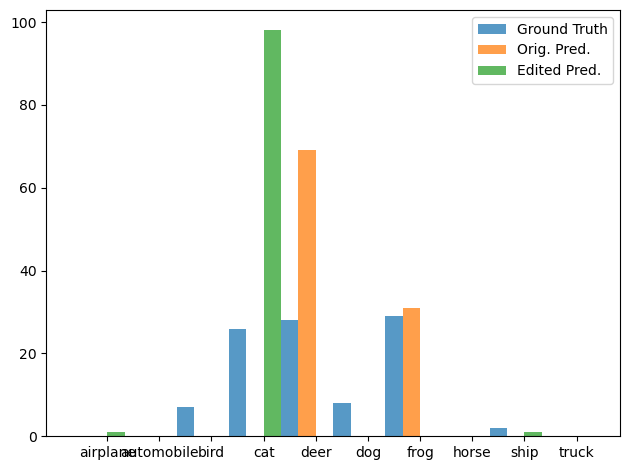

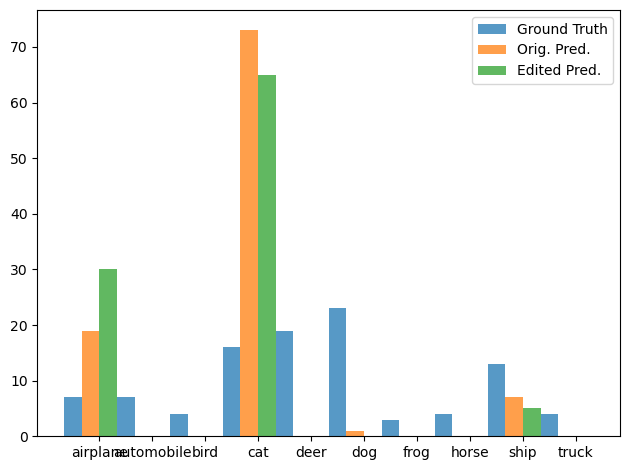

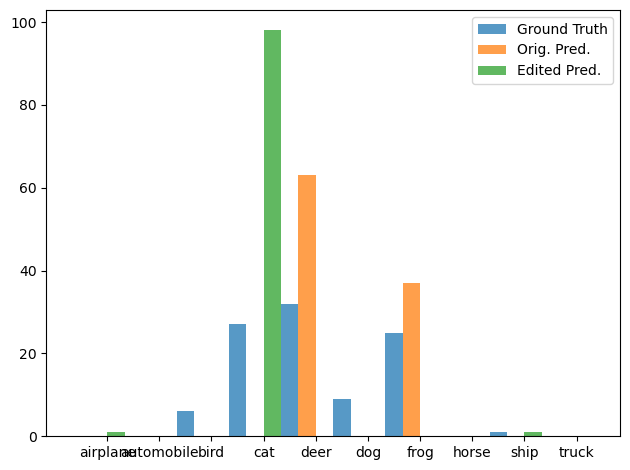

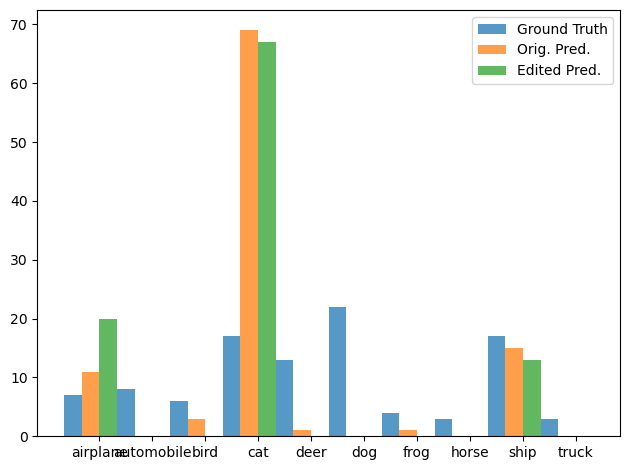

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02127052_20412/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02127052_20412/felzenszwalb_masked_softmax/models
Finished trial 11/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02127052_20412/felzenszwalb_masked_softmax
(0125_115828) Starting Trial 12/67...
Current run_id: 0125_114341/results/cat-train-n02129837_3103/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129837_3103/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-im

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.33it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 886.59it/s]

Loss (orig, final): 0.08317111432552338 0.006688578519970179
L2 norm of weight change: 0.3485906422138214
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 39.00it/s]


Post-edit metrics: {'TP': array([6121, 5180, 5044, 5053, 3616, 3114, 4882, 5195, 4646, 4669]), 'TN': array([60320, 61451, 59976, 55622, 61455, 61335, 62352, 61679, 61869,
       61461]), 'FPs': array([2680, 1549, 3024, 7378, 1545, 1665,  648, 1321, 1131, 1539]), 'FNs': array([ 879, 1820, 1956, 1947, 3384, 3886, 2118, 1805, 2354, 2331]), 'accuracy': 0.6788571428571428, 'per_class_accuracy': array([0.94915714, 0.95187143, 0.92885714, 0.86678571, 0.92958571,
       0.9207    , 0.96048571, 0.95534286, 0.95021429, 0.94471429]), 'per_class_accuracy_mean': 0.9357714285714284, 'precision': array([0.69548915, 0.76980235, 0.62518592, 0.40648379, 0.70063941,
       0.65160075, 0.88282098, 0.79726826, 0.80422365, 0.75209407]), 'precision_mean': 0.7085608328360468, 'recall': array([0.87442857, 0.74      , 0.72057143, 0.72185714, 0.51657143,
       0.44485714, 0.69742857, 0.74214286, 0.66371429, 0.667     ]), 'recall_mean': 0.6788571428571428, 'predicted_class_distribution': array([ 8801,  6729,  80

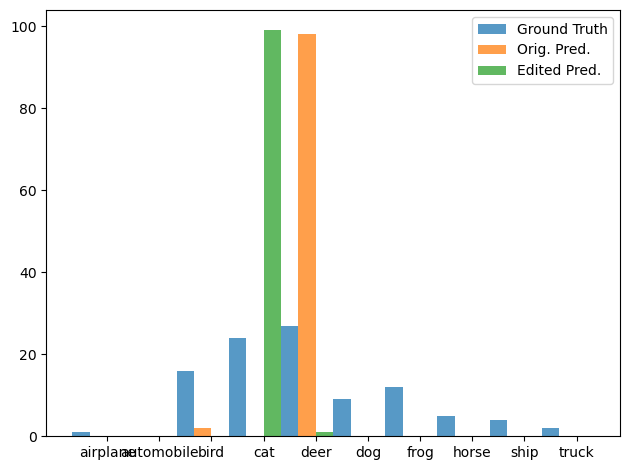

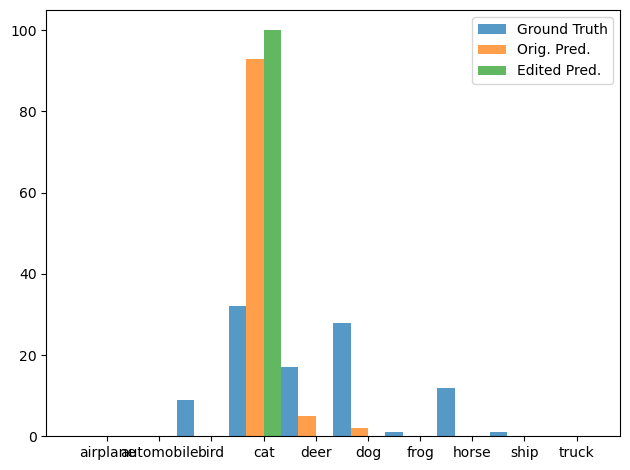

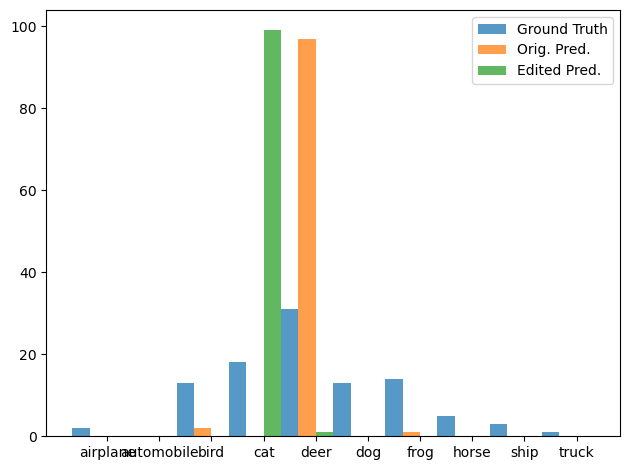

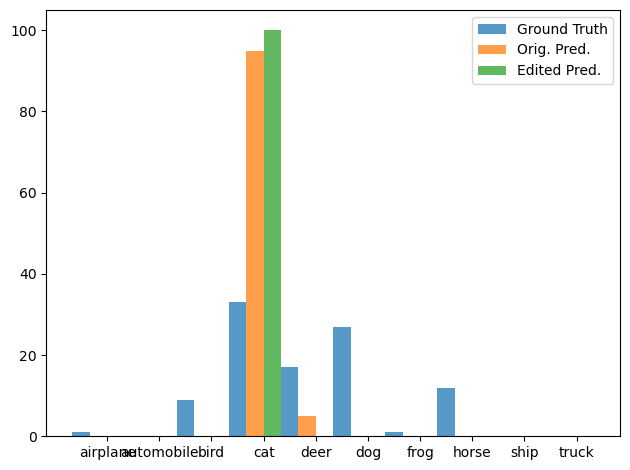

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129837_3103/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129837_3103/felzenszwalb_masked_softmax/models
Finished trial 12/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129837_3103/felzenszwalb_masked_softmax
(0125_115931) Starting Trial 13/67...
Current run_id: 0125_114341/results/cat-train-n02125311_49991/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02125311_49991/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-ima

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:04<00:00, 56.46it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 877.67it/s]

Loss (orig, final): 0.13401935994625092 0.0037119470071047544
L2 norm of weight change: 0.49778056144714355
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.54it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6192, 5303, 5150, 5093,    0, 2912, 5483, 4916, 4550, 4836]), 'TN': array([59911, 61229, 59482, 52588, 63000, 61790, 61462, 62049, 61986,
       60938]), 'FPs': array([ 3089,  1771,  3518, 10412,     0,  1210,  1538,   951,  1014,
        2062]), 'FNs': array([ 808, 1697, 1850, 1907, 7000, 4088, 1517, 2084, 2450, 2164]), 'accuracy': 0.6347857142857143, 'per_class_accuracy': array([0.94432857, 0.95045714, 0.92331429, 0.82401429, 0.9       ,
       0.92431429, 0.95635714, 0.95664286, 0.95051429, 0.93962857]), 'per_class_accuracy_mean': 0.9269571428571428, 'precision': array([0.66716949, 0.74964659, 0.59413936, 0.32847469, 0.        ,
       0.70645318, 0.78094289, 0.83790694, 0.81775701, 0.70107277]), 'precision_mean': 0.6183562912831674, 'recall': array([0.88457143, 0.75757143, 0.73571429, 0.72757143, 0.        ,
       0.416     , 0.78328571, 0.70228571, 0.65      , 0.69085714]), 'recall_mean': 0.6347857142857143, 'predicted_class_distribution': array([

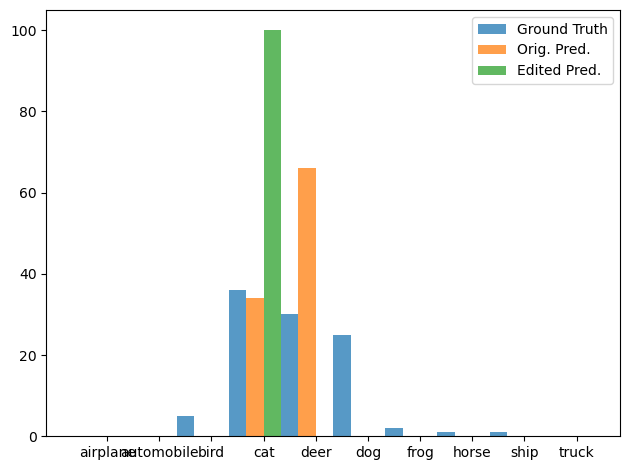

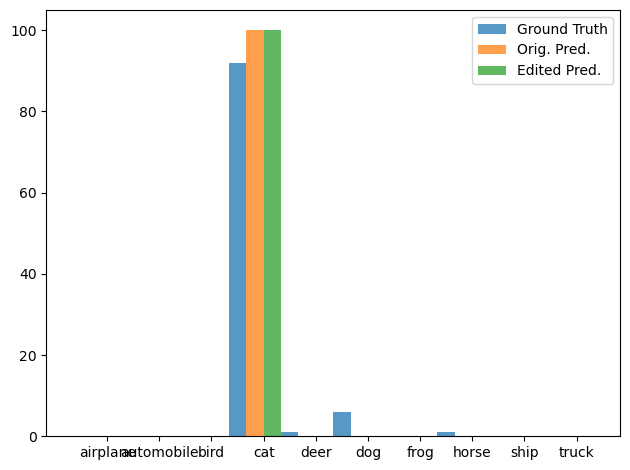

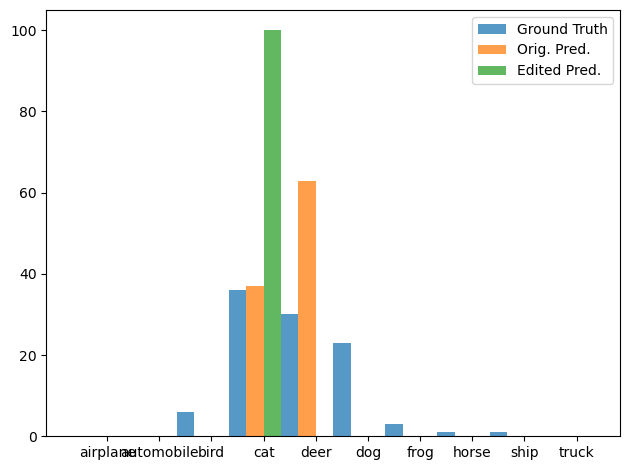

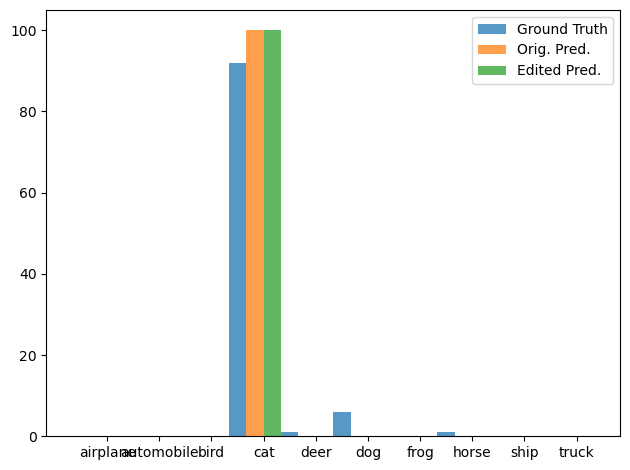

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02125311_49991/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02125311_49991/felzenszwalb_masked_softmax/models
Finished trial 13/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02125311_49991/felzenszwalb_masked_softmax
(0125_120035) Starting Trial 14/67...
Current run_id: 0125_114341/results/cat-train-n02125311_49991/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02125311_49991/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 54.08it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 877.08it/s]

Loss (orig, final): 0.03630107641220093 0.0026480054948478937
L2 norm of weight change: 0.10665427893400192
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.68it/s]


Post-edit metrics: {'TP': array([6146, 5359, 5170, 4125, 3996, 2986, 5639, 5139, 4796, 4739]), 'TN': array([60083, 61156, 59523, 59180, 60709, 61769, 61096, 61774, 61695,
       61110]), 'FPs': array([2917, 1844, 3477, 3820, 2291, 1231, 1904, 1226, 1305, 1890]), 'FNs': array([ 854, 1641, 1830, 2875, 3004, 4014, 1361, 1861, 2204, 2261]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94612857, 0.95021429, 0.92418571, 0.90435714, 0.92435714,
       0.92507143, 0.95335714, 0.9559    , 0.94987143, 0.9407    ]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.6781419 , 0.74399556, 0.59789522, 0.51919446, 0.63559726,
       0.70808632, 0.74758054, 0.80738413, 0.78610064, 0.71488912]), 'precision_mean': 0.6938865153218708, 'recall': array([0.878     , 0.76557143, 0.73857143, 0.58928571, 0.57085714,
       0.42657143, 0.80557143, 0.73414286, 0.68514286, 0.677     ]), 'recall_mean': 0.6870714285714286, 'predicted_class_distribution': array([9063, 7203, 8647,

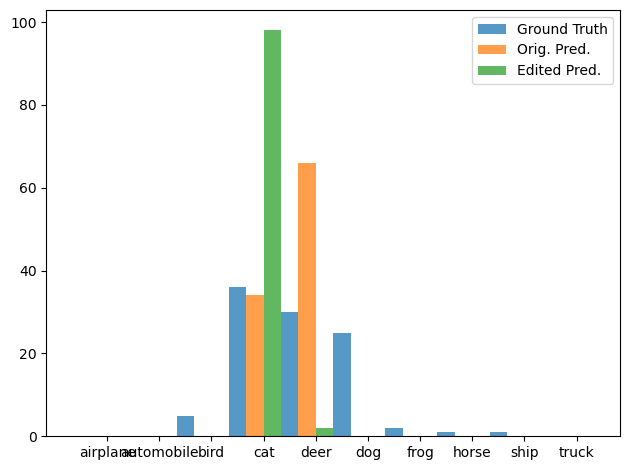

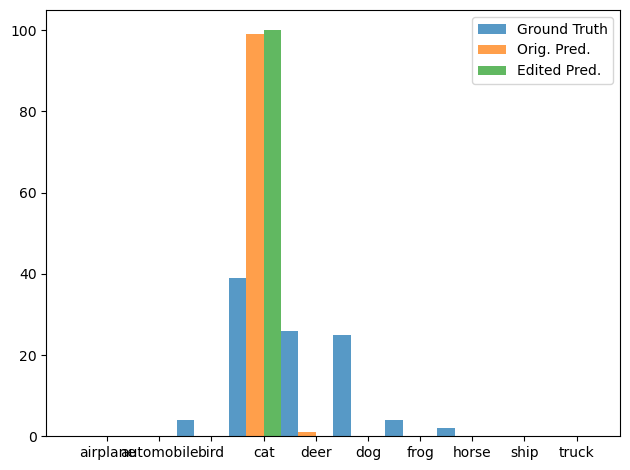

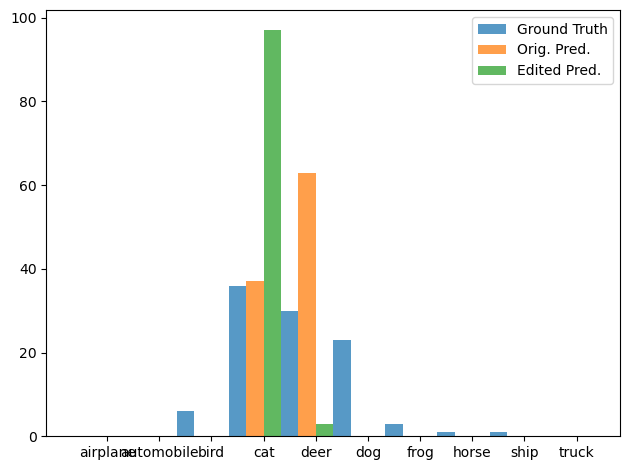

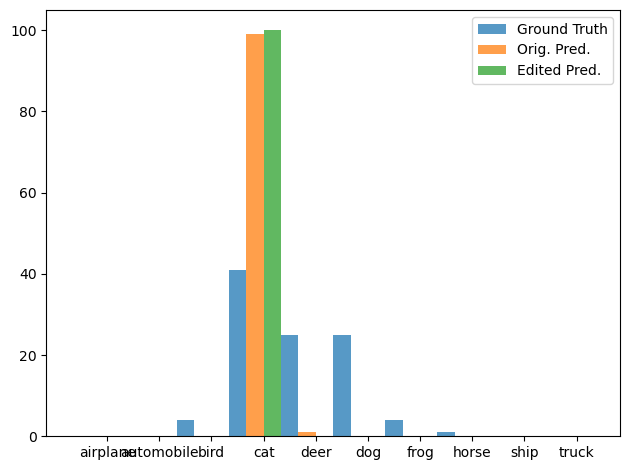

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02125311_49991/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02125311_49991/felzenszwalb_gaussian_softmax/models
Finished trial 14/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02125311_49991/felzenszwalb_gaussian_softmax
(0125_120138) Starting Trial 15/67...
Current run_id: 0125_114341/results/cat-train-n02130308_1049/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02130308_1049/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.67it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0106, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 887.72it/s]

Loss (orig, final): 0.11496084183454514 0.010563548654317856
L2 norm of weight change: 0.3477070927619934
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 27.53it/s]


Post-edit metrics: {'TP': array([6281, 5176, 5361, 4523, 3964, 2860, 4424, 5254, 4640, 4669]), 'TN': array([59139, 61441, 58689, 58019, 60712, 61896, 62603, 61427, 61870,
       61356]), 'FPs': array([3861, 1559, 4311, 4981, 2288, 1104,  397, 1573, 1130, 1644]), 'FNs': array([ 719, 1824, 1639, 2477, 3036, 4140, 2576, 1746, 2360, 2331]), 'accuracy': 0.6736, 'per_class_accuracy': array([0.93457143, 0.95167143, 0.915     , 0.89345714, 0.92394286,
       0.92508571, 0.95752857, 0.95258571, 0.95014286, 0.94321429]), 'per_class_accuracy_mean': 0.9347199999999999, 'precision': array([0.61930586, 0.76852264, 0.5542804 , 0.47590488, 0.63403711,
       0.72149344, 0.91765194, 0.76959133, 0.80415945, 0.73958498]), 'precision_mean': 0.7004532024769472, 'recall': array([0.89728571, 0.73942857, 0.76585714, 0.64614286, 0.56628571,
       0.40857143, 0.632     , 0.75057143, 0.66285714, 0.667     ]), 'recall_mean': 0.6736, 'predicted_class_distribution': array([10142,  6735,  9672,  9504,  6252,  3964,

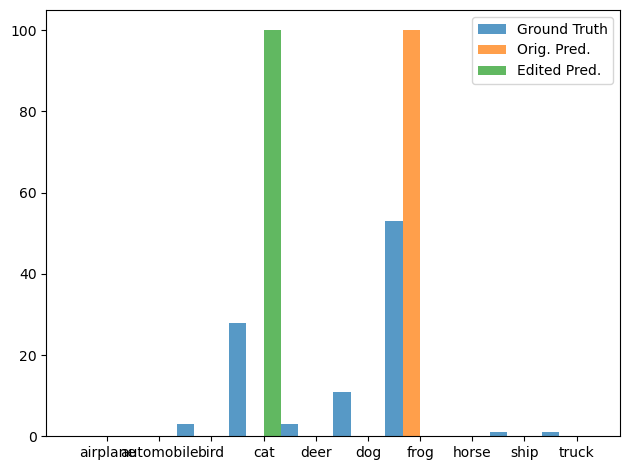

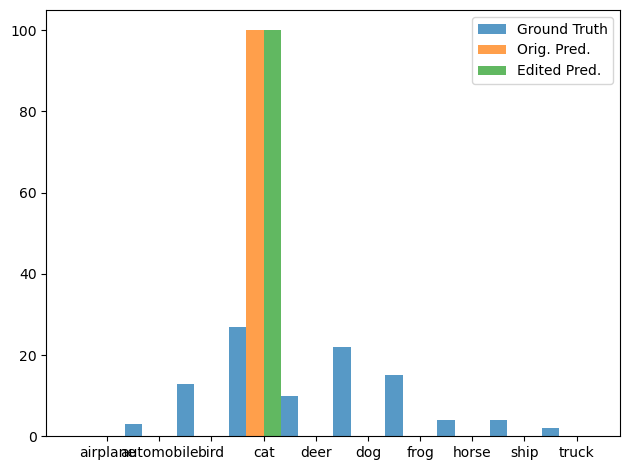

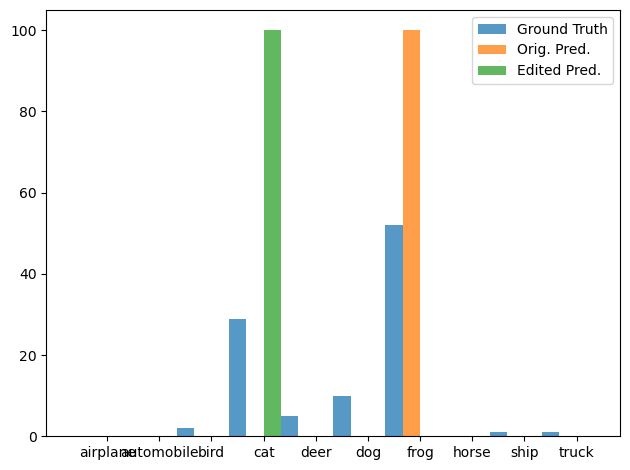

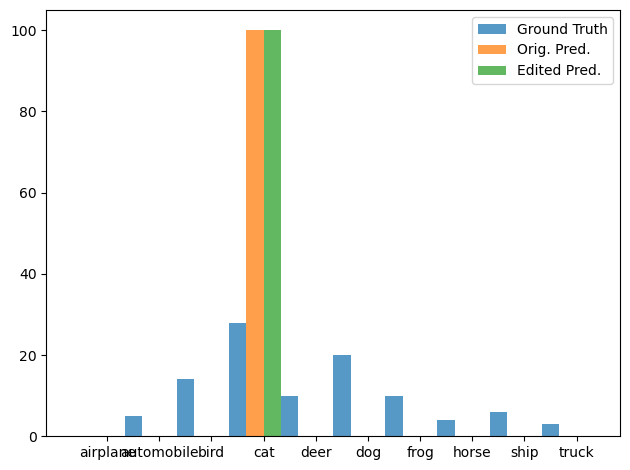

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02130308_1049/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02130308_1049/felzenszwalb_masked_softmax/models
Finished trial 15/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02130308_1049/felzenszwalb_masked_softmax
(0125_120245) Starting Trial 16/67...
Current run_id: 0125_114341/results/cat-train-n02130308_1049/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02130308_1049/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-i

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.01it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0076, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:46<00:00, 854.19it/s]

Loss (orig, final): 0.09946821630001068 0.007597317919135094
L2 norm of weight change: 0.32344508171081543
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.44it/s]


Post-edit metrics: {'TP': array([6186, 5040, 5471, 4493, 4024, 2782, 4805, 5191, 4626, 4782]), 'TN': array([59813, 61599, 58265, 58016, 60581, 61988, 62348, 61641, 61873,
       61276]), 'FPs': array([3187, 1401, 4735, 4984, 2419, 1012,  652, 1359, 1127, 1724]), 'FNs': array([ 814, 1960, 1529, 2507, 2976, 4218, 2195, 1809, 2374, 2218]), 'accuracy': 0.6771428571428572, 'per_class_accuracy': array([0.94284286, 0.95198571, 0.91051429, 0.89298571, 0.92292857,
       0.92528571, 0.95932857, 0.95474286, 0.94998571, 0.94368571]), 'per_class_accuracy_mean': 0.9354285714285714, 'precision': array([0.6599808 , 0.78248719, 0.53605722, 0.47409518, 0.62455378,
       0.73326305, 0.88052043, 0.79251908, 0.80410221, 0.73501383]), 'precision_mean': 0.7022592769955837, 'recall': array([0.88371429, 0.72      , 0.78157143, 0.64185714, 0.57485714,
       0.39742857, 0.68642857, 0.74157143, 0.66085714, 0.68314286]), 'recall_mean': 0.6771428571428572, 'predicted_class_distribution': array([ 9373,  6441, 102

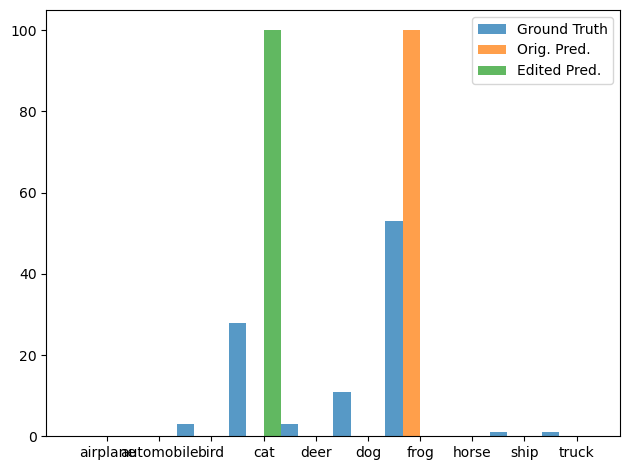

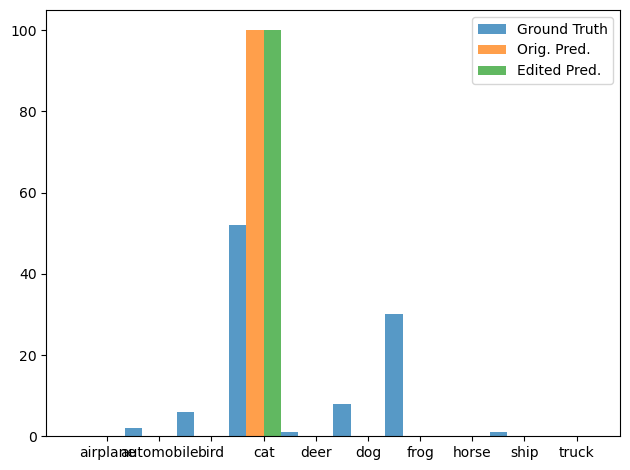

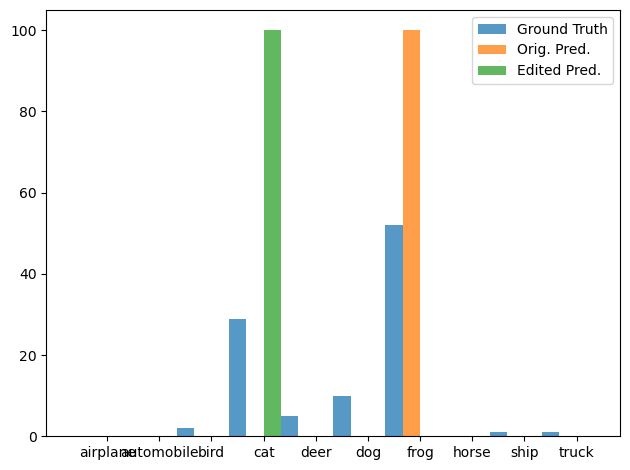

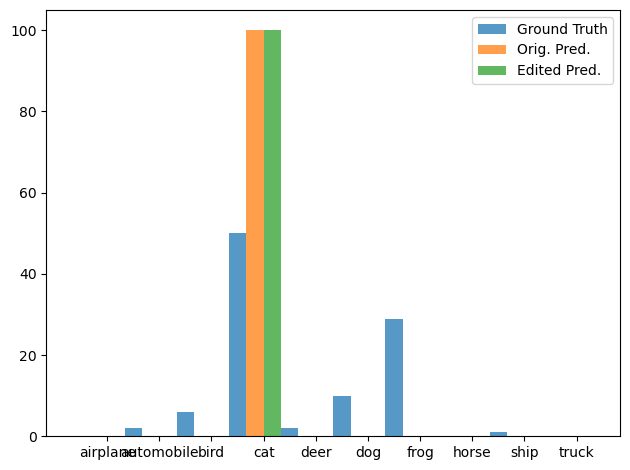

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02130308_1049/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02130308_1049/felzenszwalb_gaussian_softmax/models
Finished trial 16/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02130308_1049/felzenszwalb_gaussian_softmax
(0125_120352) Starting Trial 17/67...
Current run_id: 0125_114341/results/cat-train-n02129991_4244/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129991_4244/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:04<00:00, 54.86it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 881.49it/s]

Loss (orig, final): 0.20457325875759125 0.007338271476328373
L2 norm of weight change: 0.6603113412857056
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.10it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6153, 5231, 5115, 5441,    0, 2855, 5173, 4678, 4414, 4836]), 'TN': array([60231, 61353, 59647, 50284, 63000, 61836, 62019, 62295, 62126,
       61105]), 'FPs': array([ 2769,  1647,  3353, 12716,     0,  1164,   981,   705,   874,
        1895]), 'FNs': array([ 847, 1769, 1885, 1559, 7000, 4145, 1827, 2322, 2586, 2164]), 'accuracy': 0.6270857142857142, 'per_class_accuracy': array([0.94834286, 0.9512    , 0.92517143, 0.79607143, 0.9       ,
       0.92415714, 0.95988571, 0.95675714, 0.95057143, 0.94201429]), 'per_class_accuracy_mean': 0.925417142857143, 'precision': array([0.68964358, 0.76054085, 0.60403873, 0.29966404, 0.        ,
       0.71037572, 0.84059149, 0.86903214, 0.83472012, 0.7184668 ]), 'precision_mean': 0.632707346327775, 'recall': array([0.879     , 0.74728571, 0.73071429, 0.77728571, 0.        ,
       0.40785714, 0.739     , 0.66828571, 0.63057143, 0.69085714]), 'recall_mean': 0.6270857142857142, 'predicted_class_distribution': array([ 8

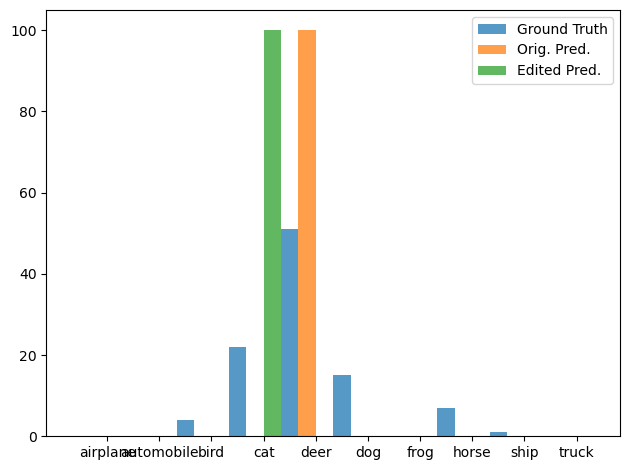

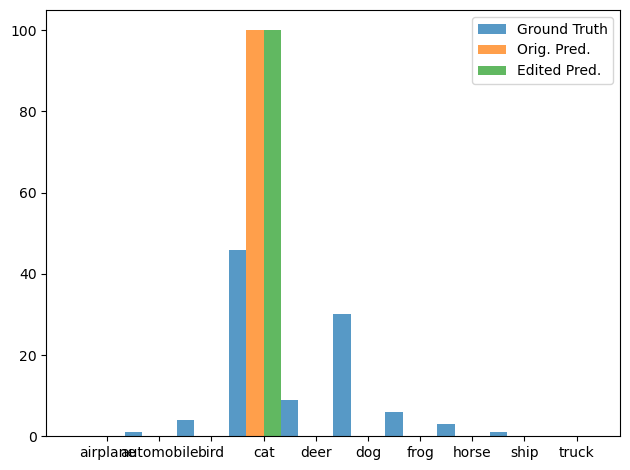

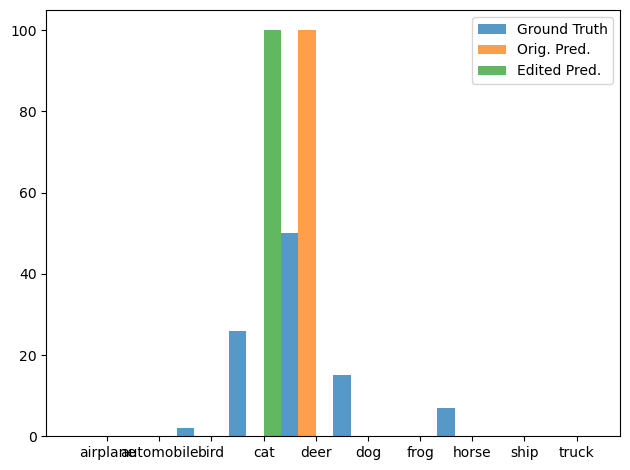

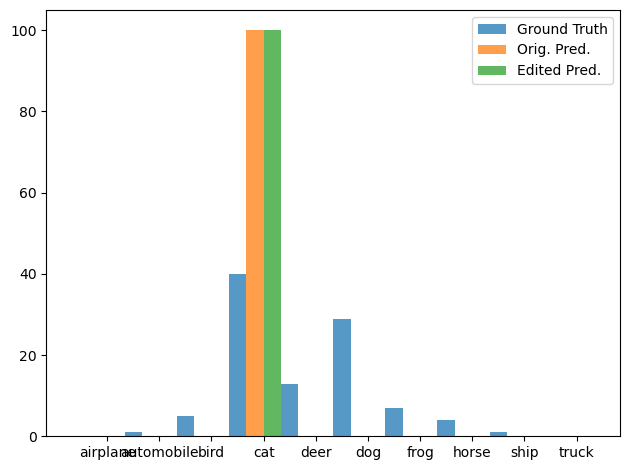

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129991_4244/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129991_4244/felzenszwalb_masked_softmax/models
Finished trial 17/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129991_4244/felzenszwalb_masked_softmax
(0125_120459) Starting Trial 18/67...
Current run_id: 0125_114341/results/cat-train-n02129991_4244/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129991_4244/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-i

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.14it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0102, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 869.96it/s]


Loss (orig, final): 0.17767049372196198 0.010231428779661655
L2 norm of weight change: 0.5618389844894409
Performing post-edit metric & KNN calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.04it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6167, 5297, 5496, 4742,    0, 2838, 5572, 4781, 4489, 4799]), 'TN': array([59938, 61243, 57775, 53835, 63000, 61940, 61137, 62240, 62032,
       61041]), 'FPs': array([3062, 1757, 5225, 9165,    0, 1060, 1863,  760,  968, 1959]), 'FNs': array([ 833, 1703, 1504, 2258, 7000, 4162, 1428, 2219, 2511, 2201]), 'accuracy': 0.6311571428571429, 'per_class_accuracy': array([0.94435714, 0.95057143, 0.90387143, 0.83681429, 0.9       ,
       0.9254    , 0.95298571, 0.95744286, 0.9503    , 0.94057143]), 'per_class_accuracy_mean': 0.9262314285714286, 'precision': array([0.66821974, 0.75092146, 0.51263875, 0.34097936, 0.        ,
       0.72806567, 0.74942838, 0.86284064, 0.82261316, 0.71012134]), 'precision_mean': 0.6145828505975123, 'recall': array([0.881     , 0.75671429, 0.78514286, 0.67742857, 0.        ,
       0.40542857, 0.796     , 0.683     , 0.64128571, 0.68557143]), 'recall_mean': 0.6311571428571429, 'predicted_class_distribution': array([ 9229,  7054, 107

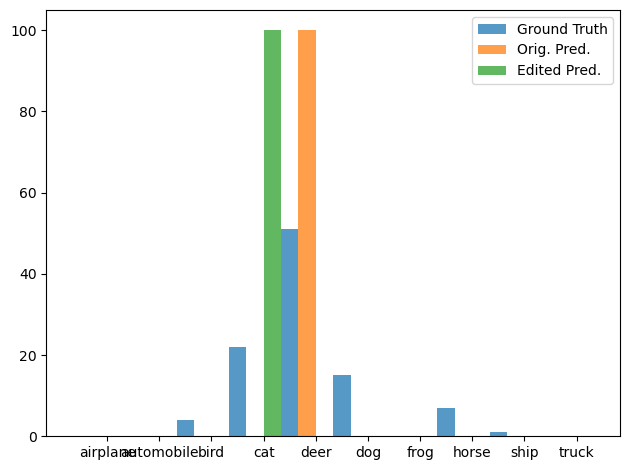

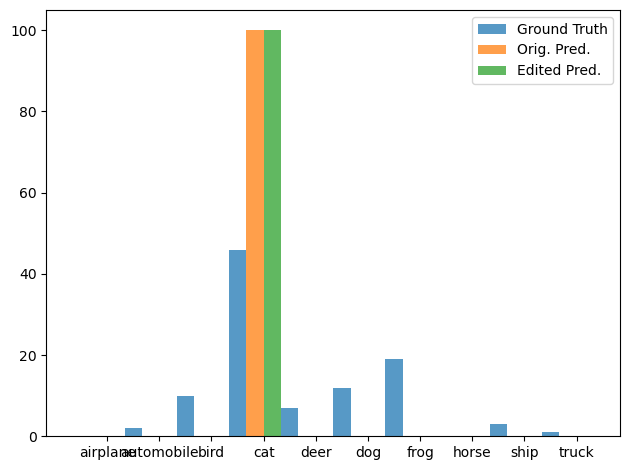

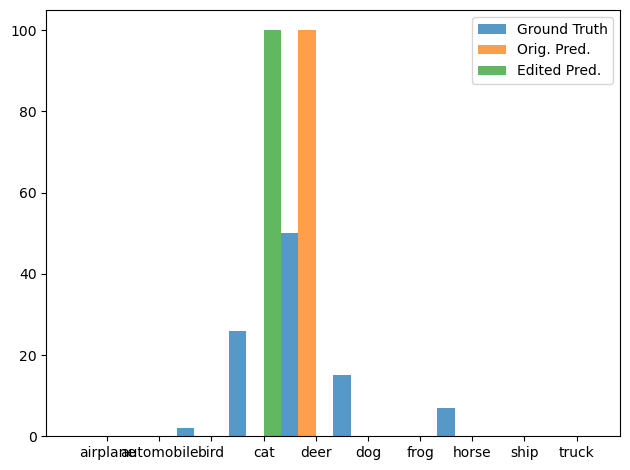

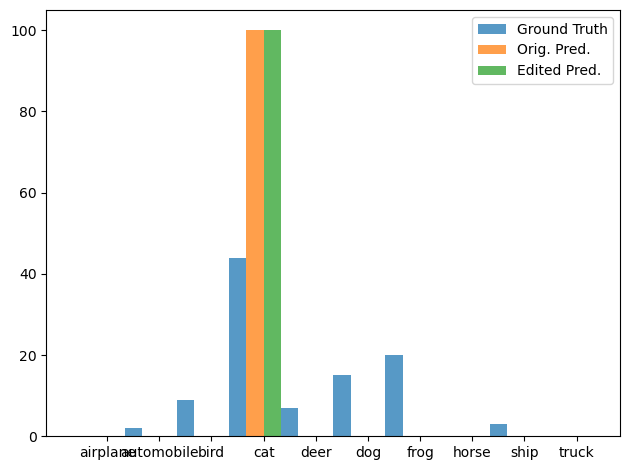

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129991_4244/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129991_4244/felzenszwalb_gaussian_softmax/models
Finished trial 18/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129991_4244/felzenszwalb_gaussian_softmax
(0125_120603) Starting Trial 19/67...
Current run_id: 0125_114341/results/cat-train-n02129165_15156/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129165_15156/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.43it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0116, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 873.35it/s]

Loss (orig, final): 0.15710598230361938 0.011556741781532764
L2 norm of weight change: 0.5277355313301086
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.21it/s]


Post-edit metrics: {'TP': array([6202, 5002,   13, 5884, 2839, 2403, 5341, 4300, 4471, 4992]), 'TN': array([60041, 61646, 63000, 44695, 62325, 62426, 61779, 62616, 62067,
       60852]), 'FPs': array([ 2959,  1354,     0, 18305,   675,   574,  1221,   384,   933,
        2148]), 'FNs': array([ 798, 1998, 6987, 1116, 4161, 4597, 1659, 2700, 2529, 2008]), 'accuracy': 0.5921, 'per_class_accuracy': array([0.94632857, 0.95211429, 0.90018571, 0.72255714, 0.93091429,
       0.92612857, 0.95885714, 0.95594286, 0.95054286, 0.94062857]), 'per_class_accuracy_mean': 0.91842, 'precision': array([0.67700033, 0.78697294, 1.        , 0.24325106, 0.80791121,
       0.80718844, 0.81392868, 0.91801879, 0.82735011, 0.69915966]), 'precision_mean': 0.7580781230536707, 'recall': array([0.886     , 0.71457143, 0.00185714, 0.84057143, 0.40557143,
       0.34328571, 0.763     , 0.61428571, 0.63871429, 0.71314286]), 'recall_mean': 0.5921000000000001, 'predicted_class_distribution': array([ 9161,  6356,    13, 24

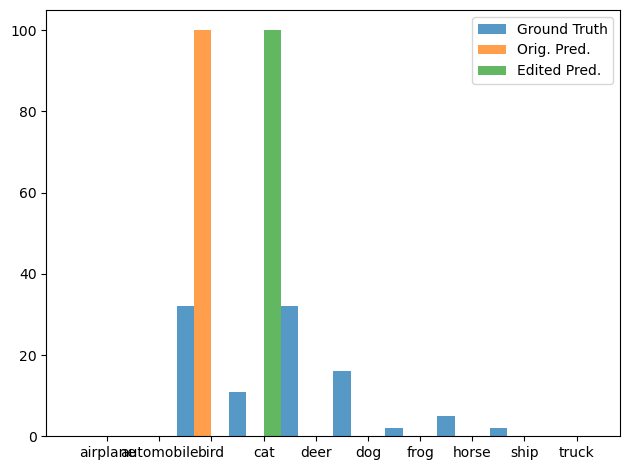

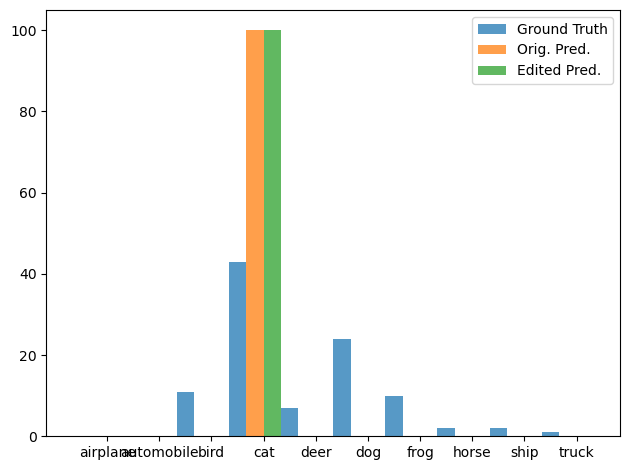

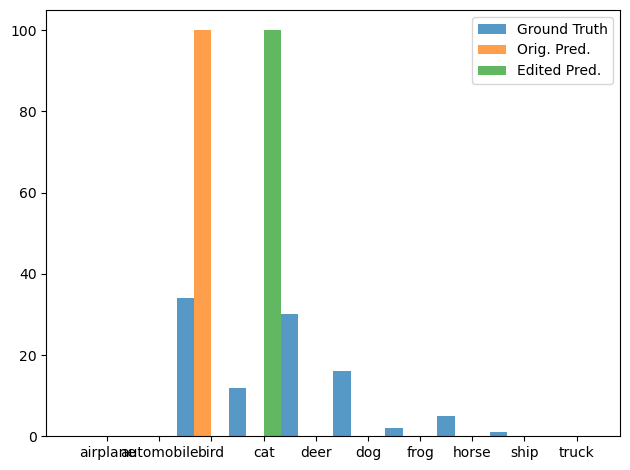

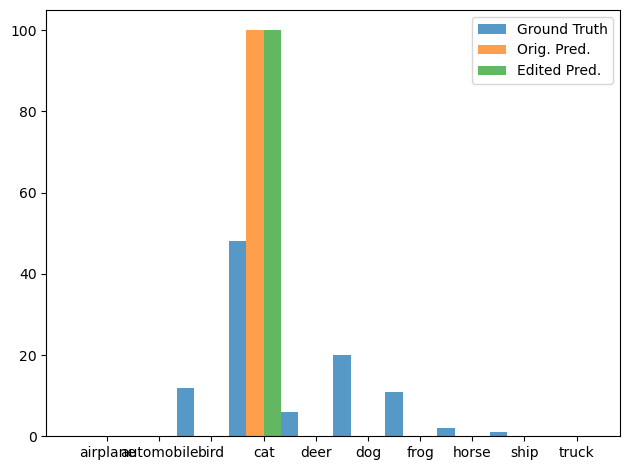

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129165_15156/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129165_15156/felzenszwalb_masked_softmax/models
Finished trial 19/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129165_15156/felzenszwalb_masked_softmax
(0125_120720) Starting Trial 20/67...
Current run_id: 0125_114341/results/cat-train-n02130308_6204/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02130308_6204/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-im

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.19it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>):  15%|█▏      | 6115/40000 [00:07<00:38, 882.42it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

tensor(0.0128, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 870.56it/s]

Loss (orig, final): 0.153231680393219 0.012827903032302856
L2 norm of weight change: 0.5113193392753601
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.57it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6204, 5095,    0, 4761, 4401, 2545, 6056, 4914, 4478, 4998]), 'TN': array([60134, 61522, 63000, 52828, 59807, 62252, 59065, 62015, 62081,
       60748]), 'FPs': array([ 2866,  1478,     0, 10172,  3193,   748,  3935,   985,   919,
        2252]), 'FNs': array([ 796, 1905, 7000, 2239, 2599, 4455,  944, 2086, 2522, 2002]), 'accuracy': 0.6207428571428572, 'per_class_accuracy': array([0.94768571, 0.95167143, 0.9       , 0.8227    , 0.91725714,
       0.92567143, 0.9303    , 0.95612857, 0.95084286, 0.93922857]), 'per_class_accuracy_mean': 0.9241485714285715, 'precision': array([0.68401323, 0.77514073, 0.        , 0.31882408, 0.57953648,
       0.7728515 , 0.60614553, 0.83302255, 0.82972021, 0.68937931]), 'precision_mean': 0.6088633620347232, 'recall': array([0.88628571, 0.72785714, 0.        , 0.68014286, 0.62871429,
       0.36357143, 0.86514286, 0.702     , 0.63971429, 0.714     ]), 'recall_mean': 0.6207428571428573, 'predicted_class_distribution': array([

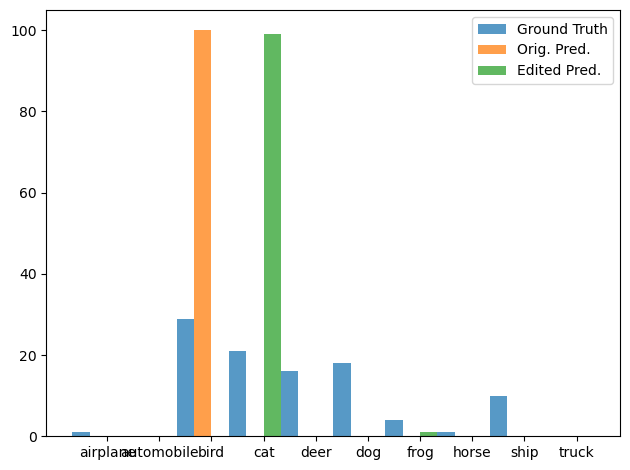

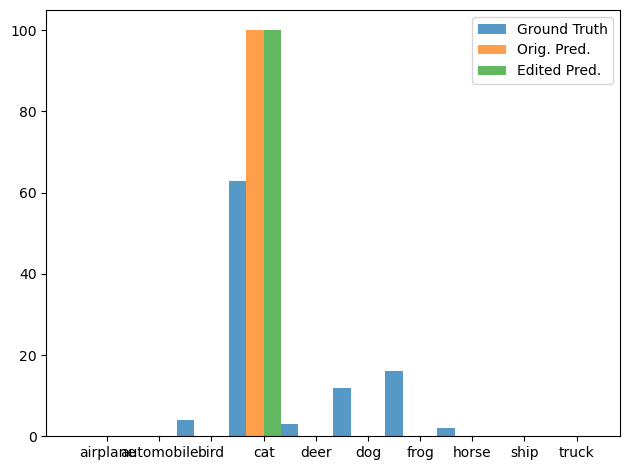

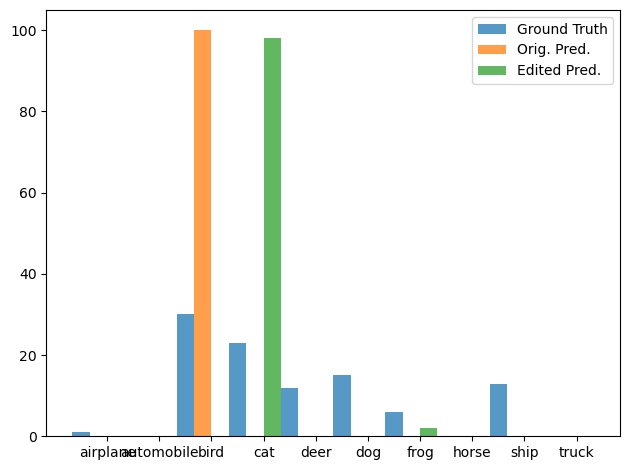

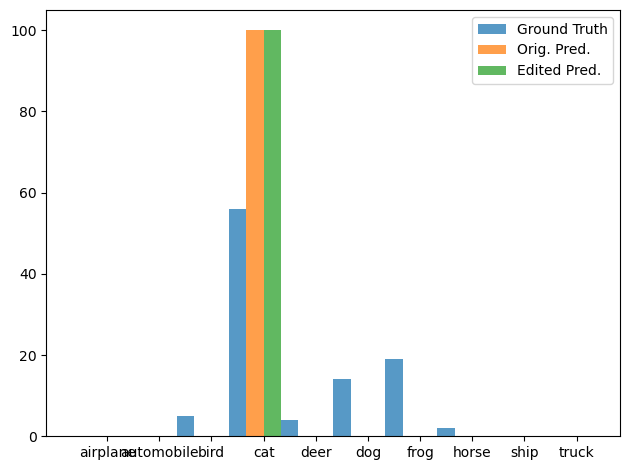

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02123159_7852/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02123159_7852/felzenszwalb_gaussian_softmax/models
Finished trial 27/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02123159_7852/felzenszwalb_gaussian_softmax
(0125_121602) Starting Trial 28/67...
Current run_id: 0125_114341/results/cat-train-n02128385_3475/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02128385_3475/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 54.18it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 871.52it/s]

Loss (orig, final): 0.14017218351364136 0.005132831633090973
L2 norm of weight change: 0.5643423199653625
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.94it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6207, 4963, 4729, 5822, 2902, 2831,    0, 5165, 4714, 4904]), 'TN': array([59897, 61682, 60774, 48201, 62270, 61813, 63000, 61720, 61790,
       61090]), 'FPs': array([ 3103,  1318,  2226, 14799,   730,  1187,     0,  1280,  1210,
        1910]), 'FNs': array([ 793, 2037, 2271, 1178, 4098, 4169, 7000, 1835, 2286, 2096]), 'accuracy': 0.6033857142857143, 'per_class_accuracy': array([0.94434286, 0.95207143, 0.93575714, 0.77175714, 0.93102857,
       0.92348571, 0.9       , 0.9555    , 0.95005714, 0.94277143]), 'per_class_accuracy_mean': 0.9206771428571429, 'precision': array([0.66670247, 0.7901608 , 0.67994249, 0.28233354, 0.79900881,
       0.70457939, 0.        , 0.80139643, 0.79574612, 0.71969475]), 'precision_mean': 0.6239564802022735, 'recall': array([0.88671429, 0.709     , 0.67557143, 0.83171429, 0.41457143,
       0.40442857, 0.        , 0.73785714, 0.67342857, 0.70057143]), 'recall_mean': 0.6033857142857142, 'predicted_class_distribution': array([

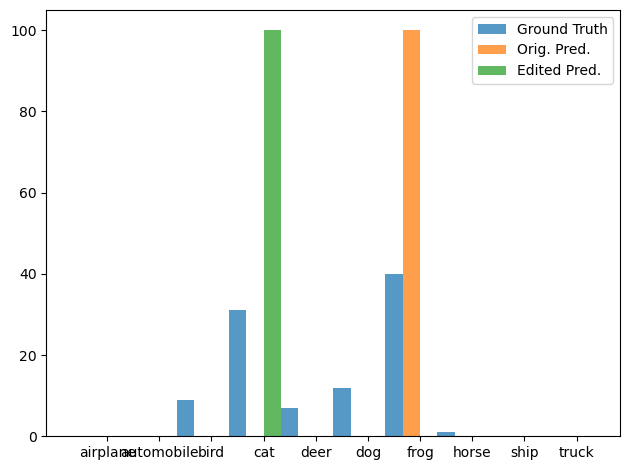

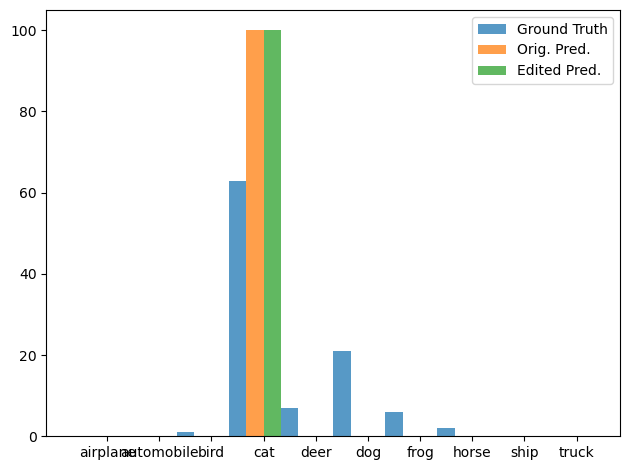

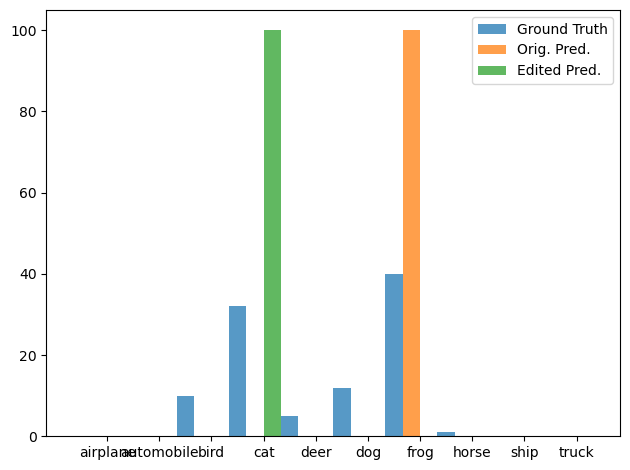

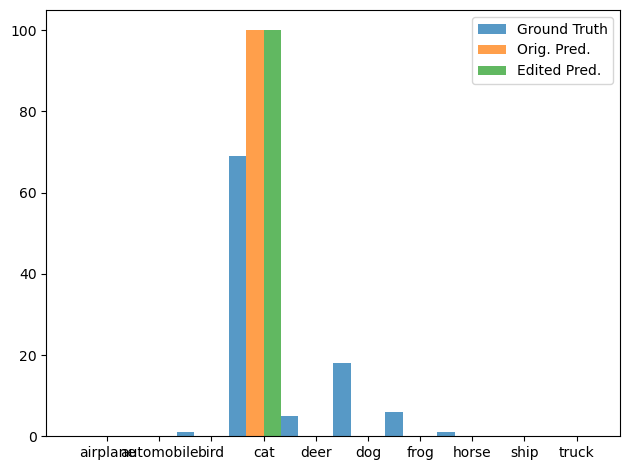

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02128385_3475/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02128385_3475/felzenszwalb_masked_softmax/models
Finished trial 28/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02128385_3475/felzenszwalb_masked_softmax
(0125_121706) Starting Trial 29/67...
Current run_id: 0125_114341/results/cat-train-n02126317_10189/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02126317_10189/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-ima

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.18it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>):  29%|██     | 11739/40000 [00:13<00:32, 880.28it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

tensor(0.0203, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 870.76it/s]

Loss (orig, final): 0.11836028844118118 0.020311210304498672
L2 norm of weight change: 0.4820880591869354
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.39it/s]


Post-edit metrics: {'TP': array([6451, 4865, 5289, 4285, 4199, 2758, 5398, 4784, 4228,   10]), 'TN': array([56937, 61746, 58853, 53552, 60187, 62026, 61617, 62164, 62185,
       63000]), 'FPs': array([6063, 1254, 4147, 9448, 2813,  974, 1383,  836,  815,    0]), 'FNs': array([ 549, 2135, 1711, 2715, 2801, 4242, 1602, 2216, 2772, 6990]), 'accuracy': 0.6038142857142857, 'per_class_accuracy': array([0.90554286, 0.95158571, 0.91631429, 0.82624286, 0.9198    ,
       0.92548571, 0.95735714, 0.9564    , 0.94875714, 0.90014286]), 'per_class_accuracy_mean': 0.9207628571428572, 'precision': array([0.51550264, 0.79506455, 0.56051293, 0.31202214, 0.59883058,
       0.73901393, 0.79604778, 0.85124555, 0.83838985, 1.        ]), 'precision_mean': 0.7006629944925691, 'recall': array([0.92157143, 0.695     , 0.75557143, 0.61214286, 0.59985714,
       0.394     , 0.77114286, 0.68342857, 0.604     , 0.00142857]), 'recall_mean': 0.6038142857142856, 'predicted_class_distribution': array([12514,  6119,  94

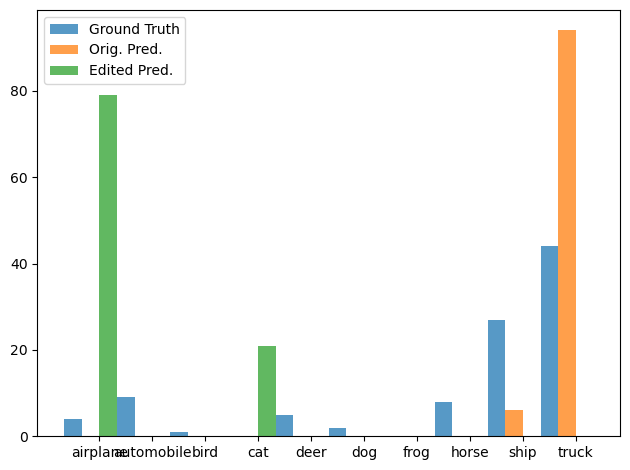

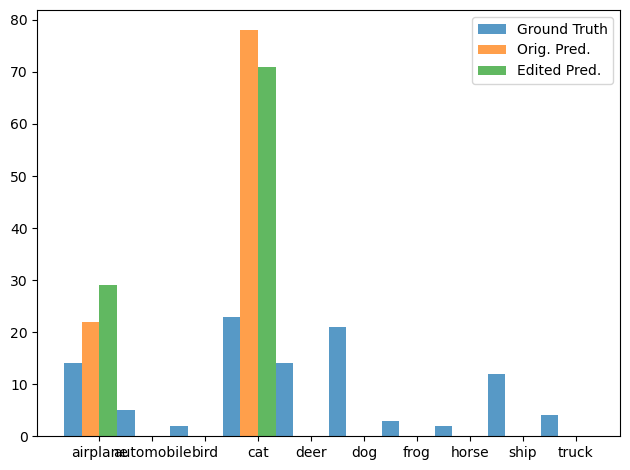

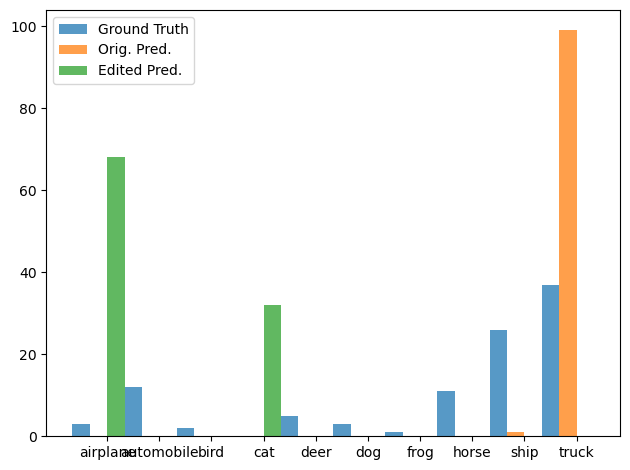

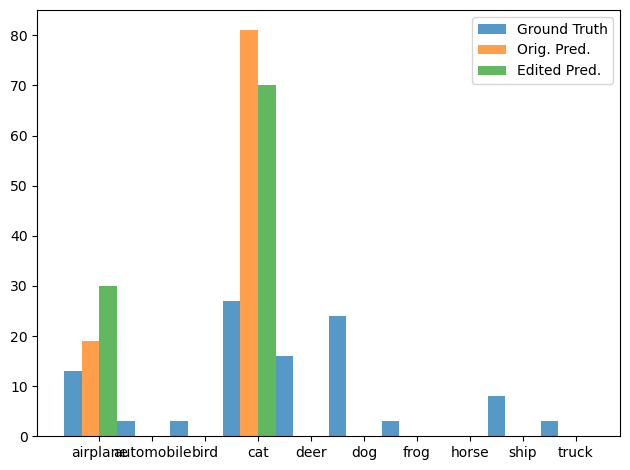

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02122725_7664/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02122725_7664/felzenszwalb_masked_softmax/models
Finished trial 36/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02122725_7664/felzenszwalb_masked_softmax
(0125_122556) Starting Trial 37/67...
Current run_id: 0125_114341/results/cat-train-n02123478_6246/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02123478_6246/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-image

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.71it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0167, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 876.27it/s]

Loss (orig, final): 0.11339753866195679 0.01666395738720894
L2 norm of weight change: 0.3755353093147278
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.23it/s]


Post-edit metrics: {'TP': array([6331, 5027, 4519, 4871, 4098, 2303, 5555, 4911, 4630, 4913]), 'TN': array([59000, 61610, 61129, 56224, 60504, 62435, 61375, 62020, 61903,
       60958]), 'FPs': array([4000, 1390, 1871, 6776, 2496,  565, 1625,  980, 1097, 2042]), 'FNs': array([ 669, 1973, 2481, 2129, 2902, 4697, 1445, 2089, 2370, 2087]), 'accuracy': 0.6736857142857143, 'per_class_accuracy': array([0.9333    , 0.95195714, 0.93782857, 0.87278571, 0.92288571,
       0.92482857, 0.95614286, 0.95615714, 0.95047143, 0.94101429]), 'per_class_accuracy_mean': 0.9347371428571428, 'precision': array([0.6128158 , 0.78338788, 0.70719875, 0.41821928, 0.62147407,
       0.80299861, 0.77367688, 0.83364454, 0.8084512 , 0.70639827]), 'precision_mean': 0.706826527113998, 'recall': array([0.90442857, 0.71814286, 0.64557143, 0.69585714, 0.58542857,
       0.329     , 0.79357143, 0.70157143, 0.66142857, 0.70185714]), 'recall_mean': 0.6736857142857142, 'predicted_class_distribution': array([10331,  6417,  639

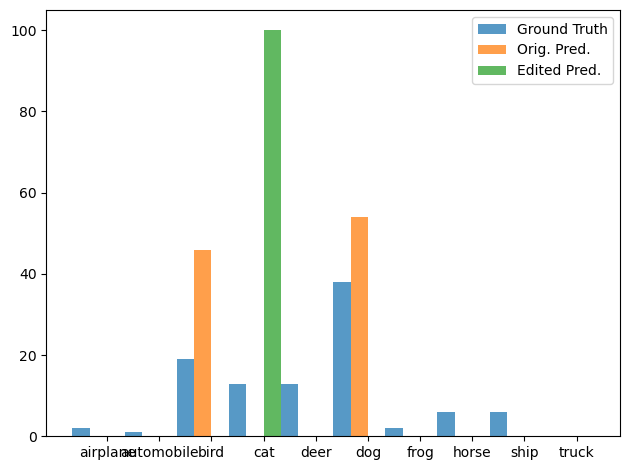

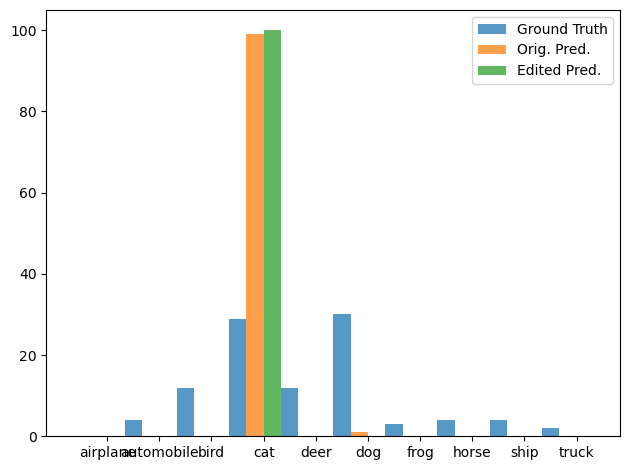

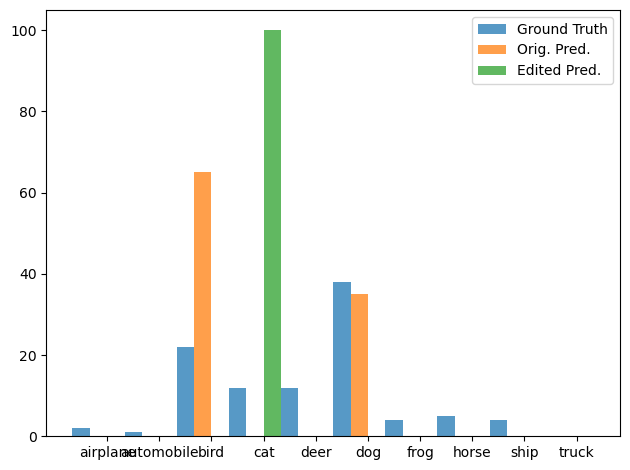

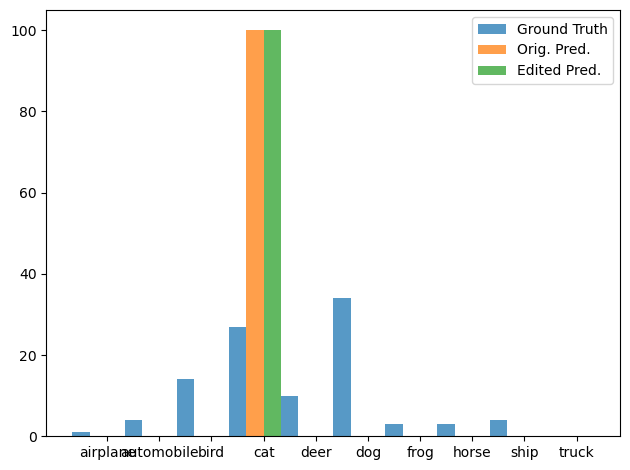

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02123478_6246/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02123478_6246/felzenszwalb_masked_softmax/models
Finished trial 37/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02123478_6246/felzenszwalb_masked_softmax
(0125_122701) Starting Trial 38/67...
Current run_id: 0125_114341/results/cat-train-n02125311_5619/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02125311_5619/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-image

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.21it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0399, device='cuda:0', grad_fn=<DivBackward0>):  82%|█████▊ | 32893/40000 [00:37<00:08, 874.99it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

tensor(0.0184, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 887.49it/s]

Loss (orig, final): 0.11256763339042664 0.01841248944401741
L2 norm of weight change: 0.2912144064903259
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.03it/s]


Post-edit metrics: {'TP': array([6242, 5037, 5044, 4199, 4421, 1949, 5681, 5038, 4721, 4995]), 'TN': array([59615, 61591, 59815, 58642, 59712, 62671, 60950, 61822, 61791,
       60718]), 'FPs': array([3385, 1409, 3185, 4358, 3288,  329, 2050, 1178, 1209, 2282]), 'FNs': array([ 758, 1963, 1956, 2801, 2579, 5051, 1319, 1962, 2279, 2005]), 'accuracy': 0.6761, 'per_class_accuracy': array([0.94081429, 0.95182857, 0.92655714, 0.89772857, 0.91618571,
       0.92314286, 0.95187143, 0.95514286, 0.95017143, 0.93875714]), 'per_class_accuracy_mean': 0.9352199999999999, 'precision': array([0.64838475, 0.78141483, 0.61295419, 0.49070936, 0.57348554,
       0.85557507, 0.73483379, 0.81048906, 0.79612142, 0.68640923]), 'precision_mean': 0.6990377229173889, 'recall': array([0.89171429, 0.71957143, 0.72057143, 0.59985714, 0.63157143,
       0.27842857, 0.81157143, 0.71971429, 0.67442857, 0.71357143]), 'recall_mean': 0.6760999999999999, 'predicted_class_distribution': array([9627, 6446, 8229, 8557, 7709,

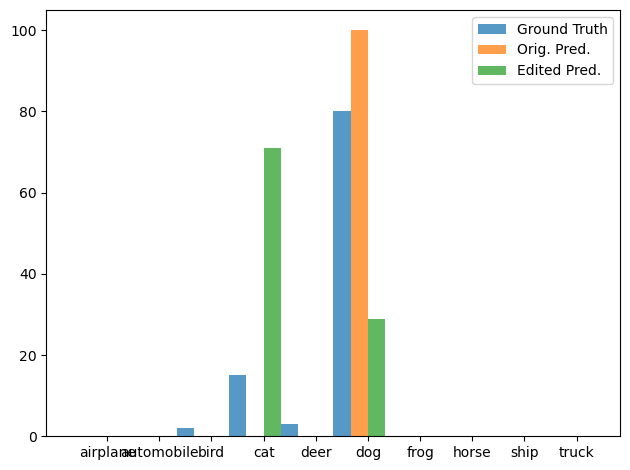

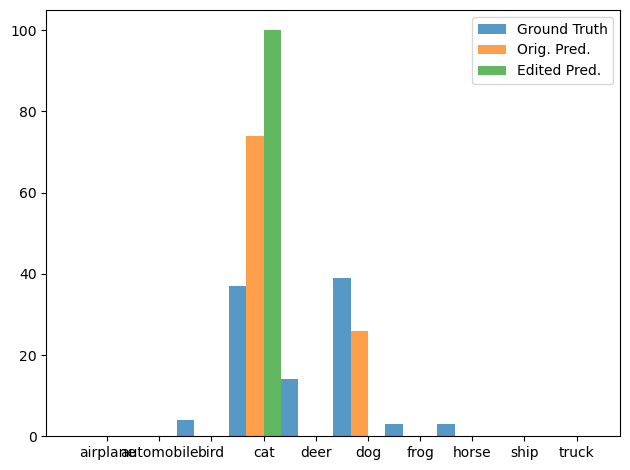

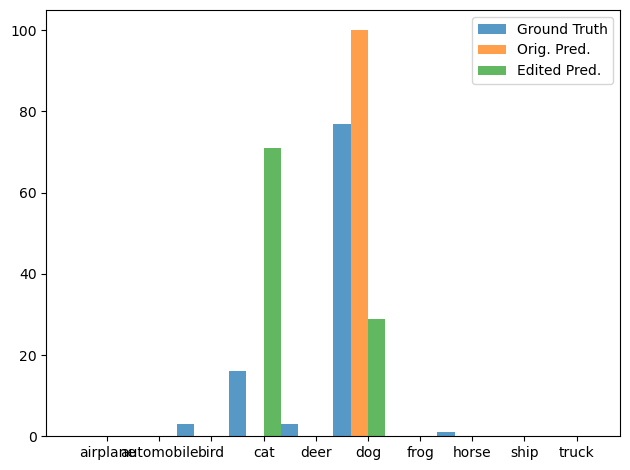

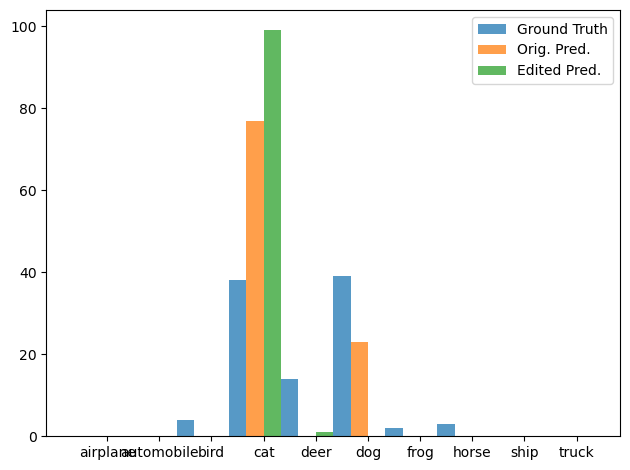

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02124484_5305/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02124484_5305/felzenszwalb_gaussian_softmax/models
Finished trial 45/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02124484_5305/felzenszwalb_gaussian_softmax
(0125_123709) Starting Trial 46/67...
Current run_id: 0125_114341/results/cat-train-n02127808_2078/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02127808_2078/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.98it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0208, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 879.39it/s]

Loss (orig, final): 0.14402355253696442 0.020849987864494324
L2 norm of weight change: 0.44019946455955505
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.41it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6284, 5207, 4607, 4823, 4269, 2990,    0, 5084, 5035, 4664]), 'TN': array([58806, 61386, 60868, 52939, 60000, 61724, 63000, 61783, 61220,
       61237]), 'FPs': array([ 4194,  1614,  2132, 10061,  3000,  1276,     0,  1217,  1780,
        1763]), 'FNs': array([ 716, 1793, 2393, 2177, 2731, 4010, 7000, 1916, 1965, 2336]), 'accuracy': 0.6137571428571429, 'per_class_accuracy': array([0.92985714, 0.95132857, 0.93535714, 0.82517143, 0.91812857,
       0.92448571, 0.9       , 0.95524286, 0.9465    , 0.94144286]), 'per_class_accuracy_mean': 0.9227514285714286, 'precision': array([0.59973277, 0.7633778 , 0.68363259, 0.32403924, 0.58728849,
       0.70089076, 0.        , 0.80685605, 0.73881145, 0.7256885 ]), 'precision_mean': 0.5930317651572635, 'recall': array([0.89771429, 0.74385714, 0.65814286, 0.689     , 0.60985714,
       0.42714286, 0.        , 0.72628571, 0.71928571, 0.66628571]), 'recall_mean': 0.6137571428571429, 'predicted_class_distribution': array([

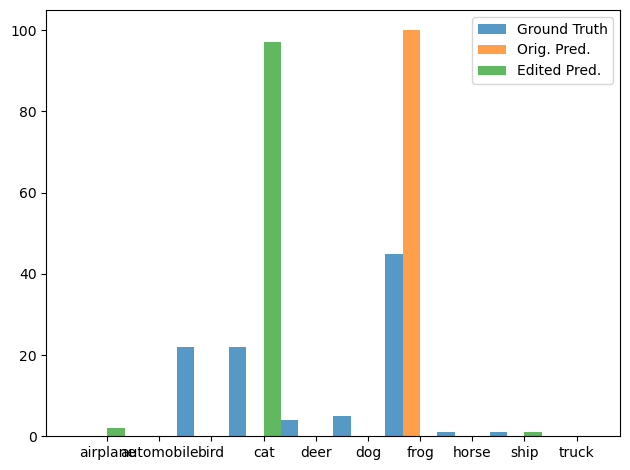

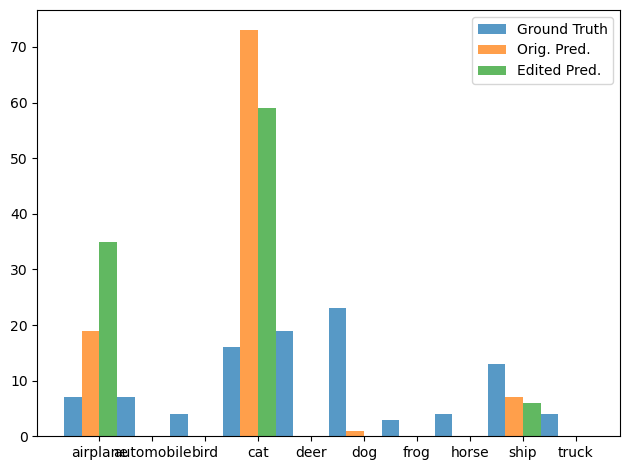

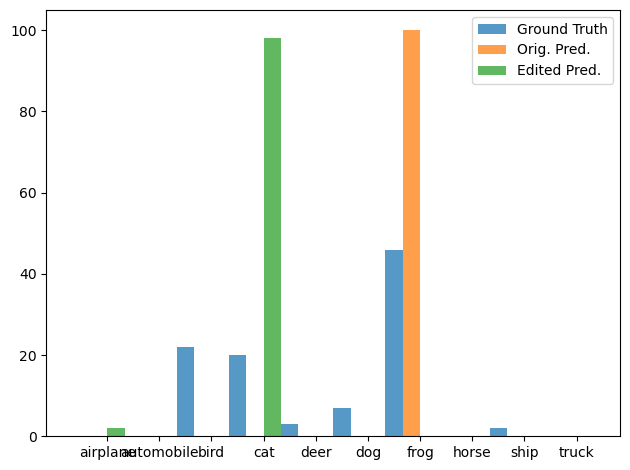

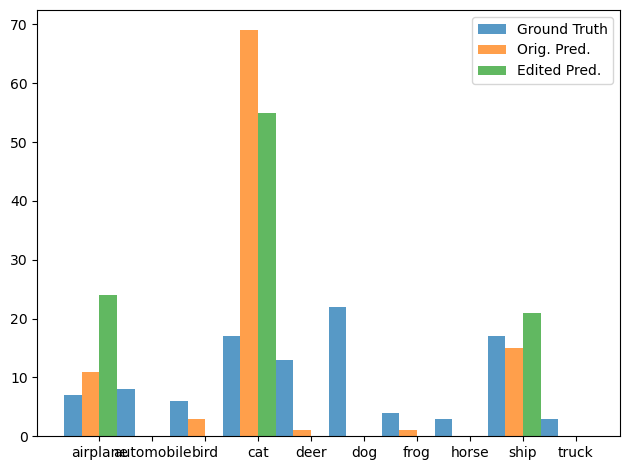

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02127808_2078/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02127808_2078/felzenszwalb_masked_softmax/models
Finished trial 46/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02127808_2078/felzenszwalb_masked_softmax
(0125_123816) Starting Trial 47/67...
Current run_id: 0125_114341/results/cat-train-n02129991_1363/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129991_1363/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-image

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.77it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0147, device='cuda:0', grad_fn=<DivBackward0>):  84%|█████▉ | 33753/40000 [00:38<00:07, 888.66it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.74it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 879.29it/s]

Loss (orig, final): 0.022820714861154556 0.0028441711328923702
L2 norm of weight change: 0.13491930067539215
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.94it/s]


Post-edit metrics: {'TP': array([6093, 5301, 5035, 4097, 4289, 2941, 5686, 5054, 4911, 4750]), 'TN': array([60333, 61267, 59918, 59130, 60093, 61797, 60991, 61909, 61560,
       61159]), 'FPs': array([2667, 1733, 3082, 3870, 2907, 1203, 2009, 1091, 1440, 1841]), 'FNs': array([ 907, 1699, 1965, 2903, 2711, 4059, 1314, 1946, 2089, 2250]), 'accuracy': 0.6879571428571428, 'per_class_accuracy': array([0.94894286, 0.95097143, 0.9279    , 0.90324286, 0.91974286,
       0.92482857, 0.95252857, 0.95661429, 0.94958571, 0.94155714]), 'per_class_accuracy_mean': 0.9375914285714286, 'precision': array([0.69554795, 0.75362525, 0.62030307, 0.51424627, 0.59602557,
       0.70970077, 0.73892138, 0.82245728, 0.77326405, 0.72067971]), 'precision_mean': 0.6944771296970103, 'recall': array([0.87042857, 0.75728571, 0.71928571, 0.58528571, 0.61271429,
       0.42014286, 0.81228571, 0.722     , 0.70157143, 0.67857143]), 'recall_mean': 0.6879571428571429, 'predicted_class_distribution': array([8760, 7034, 8117,

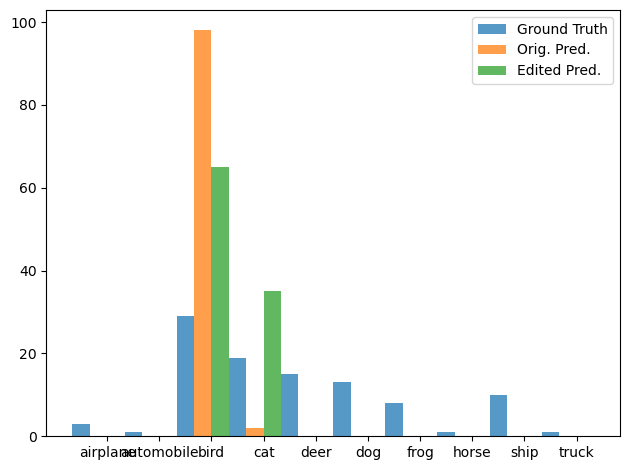

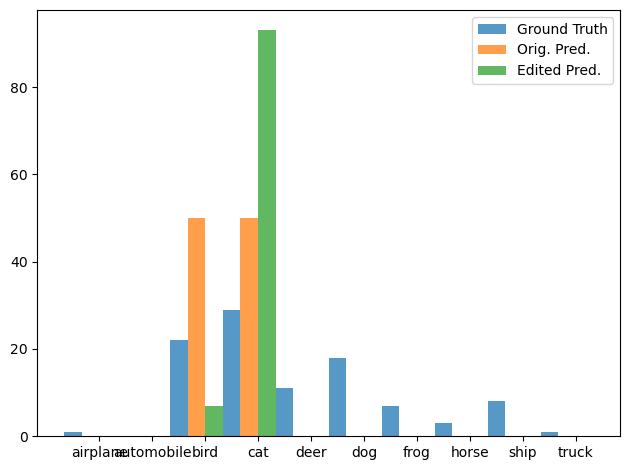

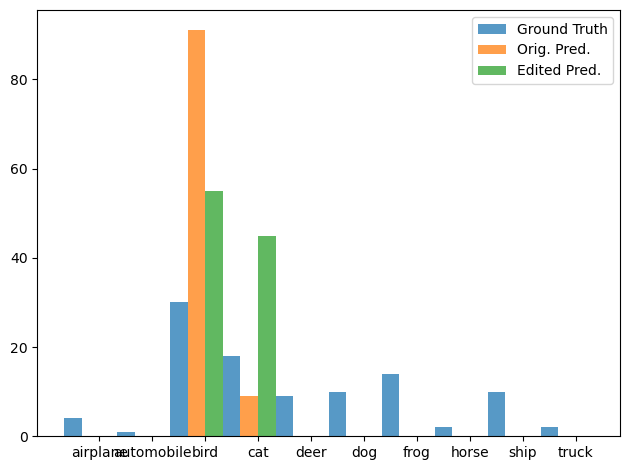

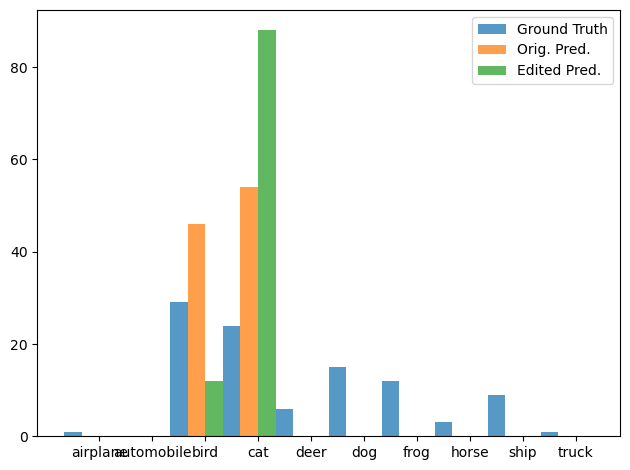

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02125494_5963/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02125494_5963/felzenszwalb_gaussian_softmax/models
Finished trial 55/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02125494_5963/felzenszwalb_gaussian_softmax
(0125_124801) Starting Trial 56/67...
Current run_id: 0125_114341/results/cat-train-n02125494_5297/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02125494_5297/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.09it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0263, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 877.13it/s]

Loss (orig, final): 0.15342684090137482 0.026327665895223618
L2 norm of weight change: 0.37651869654655457
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.40it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6174, 5126, 5189, 4851, 4096, 2928,    0, 5137, 4944, 4818]), 'TN': array([59850, 61498, 59502, 52791, 60488, 61832, 63000, 61738, 61449,
       61115]), 'FPs': array([ 3150,  1502,  3498, 10209,  2512,  1168,     0,  1262,  1551,
        1885]), 'FNs': array([ 826, 1874, 1811, 2149, 2904, 4072, 7000, 1863, 2056, 2182]), 'accuracy': 0.6180428571428571, 'per_class_accuracy': array([0.9432    , 0.95177143, 0.92415714, 0.82345714, 0.92262857,
       0.92514286, 0.9       , 0.95535714, 0.94847143, 0.9419    ]), 'per_class_accuracy_mean': 0.9236085714285714, 'precision': array([0.66216216, 0.77338564, 0.59732934, 0.32211155, 0.61985472,
       0.71484375, 0.        , 0.80278168, 0.76120092, 0.71878263]), 'precision_mean': 0.597245240995242, 'recall': array([0.882     , 0.73228571, 0.74128571, 0.693     , 0.58514286,
       0.41828571, 0.        , 0.73385714, 0.70628571, 0.68828571]), 'recall_mean': 0.6180428571428572, 'predicted_class_distribution': array([ 

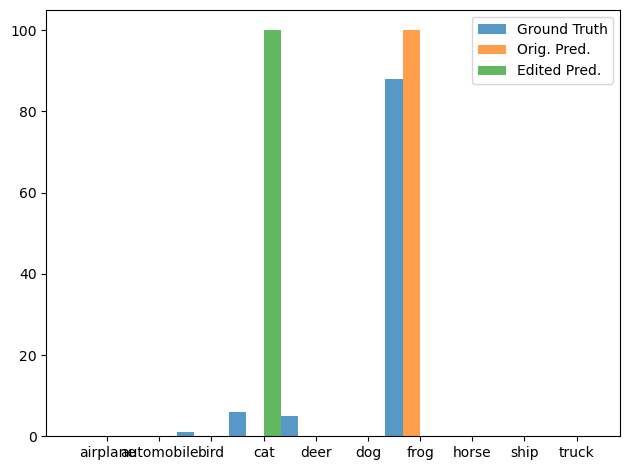

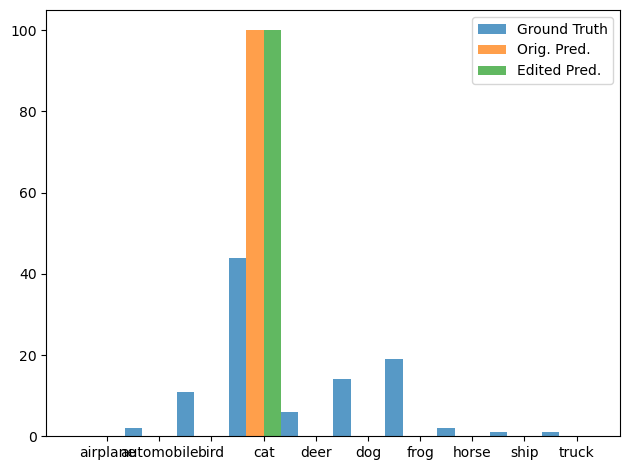

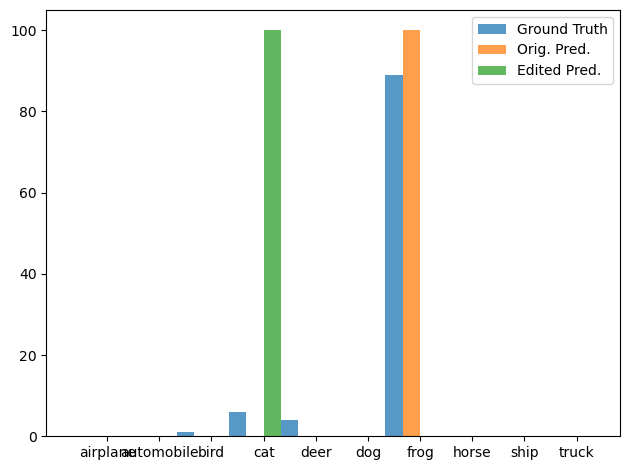

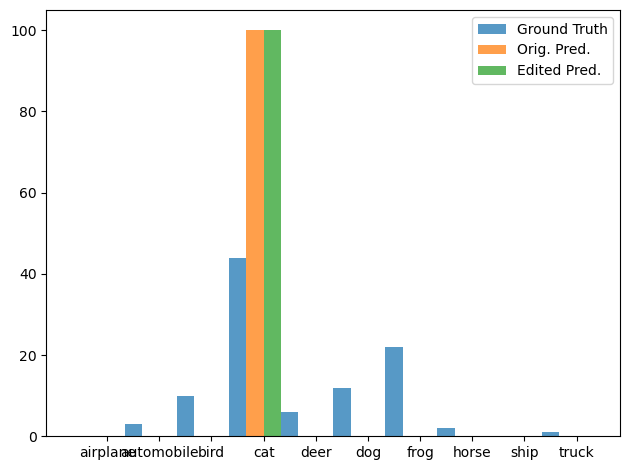

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02125494_5297/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02125494_5297/felzenszwalb_masked_softmax/models
Finished trial 56/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02125494_5297/felzenszwalb_masked_softmax
(0125_124906) Starting Trial 57/67...
Current run_id: 0125_114341/results/cat-train-n02125311_6009/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02125311_6009/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-image

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.24it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0176, device='cuda:0', grad_fn=<DivBackward0>):  19%|█▌      | 7761/40000 [00:08<00:36, 873.80it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

tensor(0.0419, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 875.32it/s]

Loss (orig, final): 0.16310431063175201 0.04189176484942436
L2 norm of weight change: 0.4357663691043854
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.85it/s]


Post-edit metrics: {'TP': array([6322, 5112, 4783, 4035, 4406, 2051, 5861, 4815, 4778, 4959]), 'TN': array([58892, 61454, 60548, 59120, 59777, 62645, 60472, 62068, 61657,
       60489]), 'FPs': array([4108, 1546, 2452, 3880, 3223,  355, 2528,  932, 1343, 2511]), 'FNs': array([ 678, 1888, 2217, 2965, 2594, 4949, 1139, 2185, 2222, 2041]), 'accuracy': 0.6731714285714285, 'per_class_accuracy': array([0.93162857, 0.95094286, 0.9333    , 0.90221429, 0.9169    ,
       0.92422857, 0.94761429, 0.95547143, 0.94907143, 0.93497143]), 'per_class_accuracy_mean': 0.9346342857142856, 'precision': array([0.60613615, 0.76779814, 0.66109191, 0.50979154, 0.5775331 ,
       0.8524522 , 0.698653  , 0.83782843, 0.78059141, 0.66385542]), 'precision_mean': 0.6955731291414282, 'recall': array([0.90314286, 0.73028571, 0.68328571, 0.57642857, 0.62942857,
       0.293     , 0.83728571, 0.68785714, 0.68257143, 0.70842857]), 'recall_mean': 0.6731714285714286, 'predicted_class_distribution': array([10430,  6658,  72

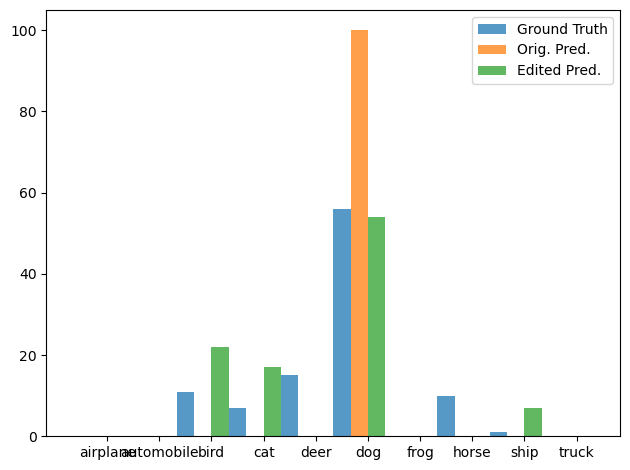

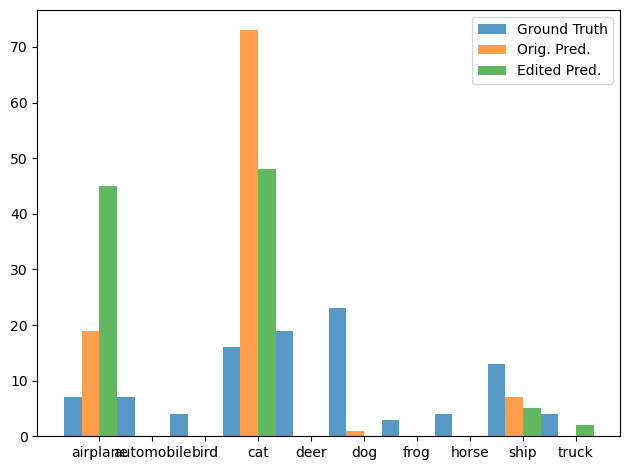

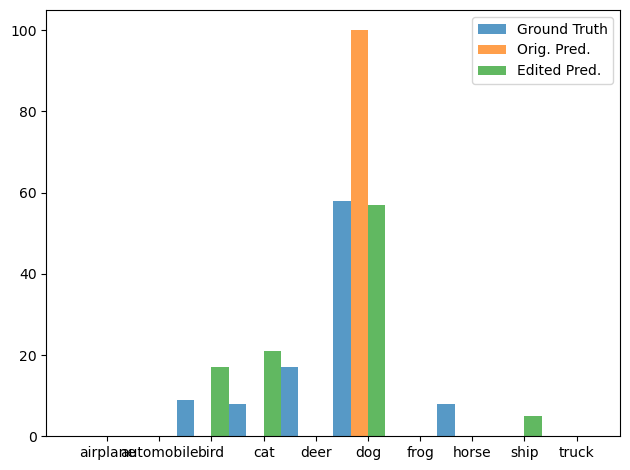

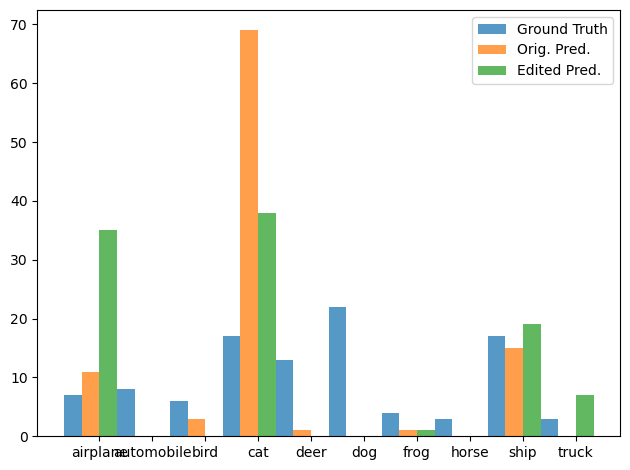

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129991_438/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129991_438/felzenszwalb_masked_softmax/models
Finished trial 64/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129991_438/felzenszwalb_masked_softmax
(0125_125834) Starting Trial 65/67...
Current run_id: 0125_114341/results/cat-train-n02126640_2067/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02126640_2067/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.59it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 871.59it/s]

Loss (orig, final): 0.14432552456855774 0.003188083181157708
L2 norm of weight change: 0.7068139910697937
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:28<00:00,  9.76it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([5728,    0, 2241, 6089, 3620, 2511, 4578, 3511, 3224,    0]), 'TN': array([61695, 63000, 62920, 34460, 61419, 56902, 62536, 62850, 62720,
       63000]), 'FPs': array([ 1305,     0,    80, 28540,  1581,  6098,   464,   150,   280,
           0]), 'FNs': array([1272, 7000, 4759,  911, 3380, 4489, 2422, 3489, 3776, 7000]), 'accuracy': 0.45002857142857144, 'per_class_accuracy': array([0.96318571, 0.9       , 0.93087143, 0.57927143, 0.92912857,
       0.84875714, 0.95877143, 0.94801429, 0.94205714, 0.9       ]), 'per_class_accuracy_mean': 0.8900057142857143, 'precision': array([0.81444618, 0.        , 0.9655321 , 0.17583528, 0.69602   ,
       0.29167151, 0.90797303, 0.95902759, 0.92009132, 0.        ]), 'precision_mean': 0.5730597004669515, 'recall': array([0.81828571, 0.        , 0.32014286, 0.86985714, 0.51714286,
       0.35871429, 0.654     , 0.50157143, 0.46057143, 0.        ]), 'recall_mean': 0.4500285714285715, 'predicted_class_distribution': array(

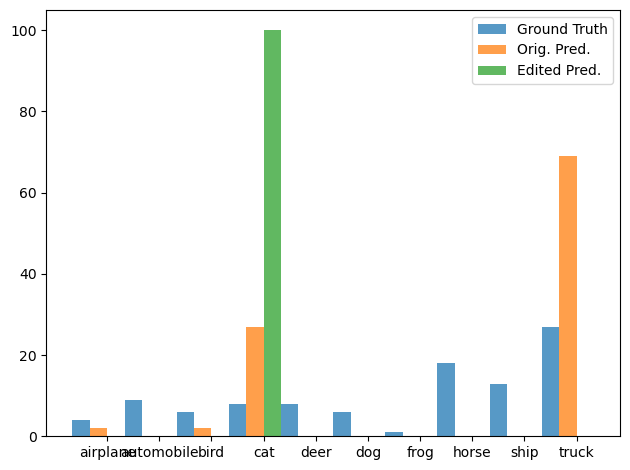

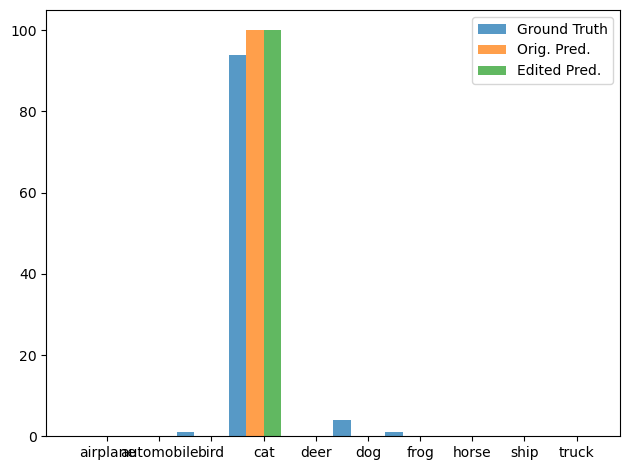

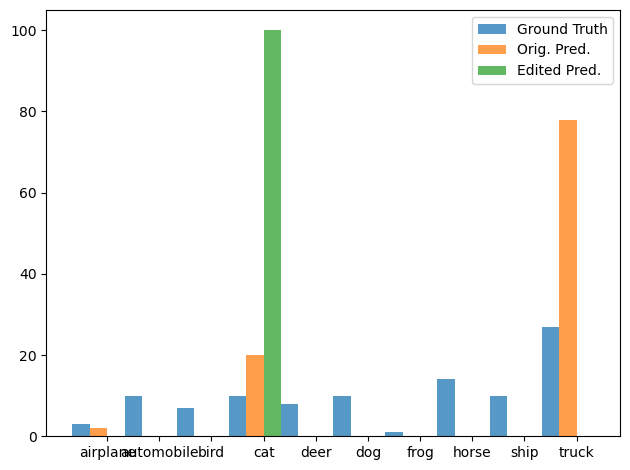

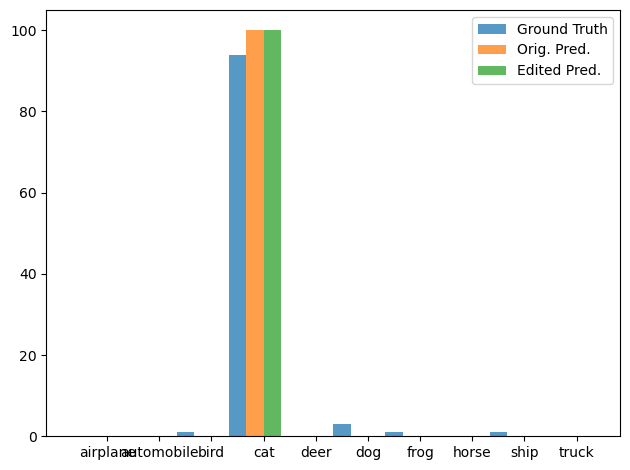

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02126640_2067/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02126640_2067/felzenszwalb_masked_softmax/models
Finished trial 65/67. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02126640_2067/felzenszwalb_masked_softmax
(0125_130003) Starting Trial 66/67...
Current run_id: 0125_114341/results/cat-train-n02129463_8239/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results/cat-train-n02129463_8239/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-image

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 18.79it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0677, device='cuda:0', grad_fn=<DivBackward0>):  61%|████▎  | 24551/40000 [00:27<00:17, 885.60it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [9]:
for idx, (key_path, value_path) in enumerate(zip(key_image_paths, value_image_paths)):
    split = os.path.basename(os.path.dirname(os.path.dirname(key_path)))
    class_name = os.path.basename(os.path.dirname(key_path))
    file_name = os.path.basename(key_path).split(".")[0]
    key_image_id = "{}-{}-{}".format(class_name, split, file_name)
    # Print Progress
    informal_log("({}) Starting Trial {}/{}...".format(datetime.now().strftime(r'%m%d_%H%M%S'), idx + 1, n_trials), progress_report_path)
    
    # Create run id 
    value_image_id = os.path.splitext(os.path.basename(value_path))[0]
    run_id = os.path.join(timestamp, 'results', key_image_id, value_image_id)
    informal_log("Current run_id: {}".format(run_id), progress_report_path)
    
    # Read config file as json and make updates to key and value paths
    config_dict = read_json(config_path)
    config_dict['editor'].update({
        'key_paths_file': key_path,
        'value_paths_file': value_path
    })
    
    # Create config object
    config = ConfigParser(config_dict, run_id=run_id)
    
    # Log the current trial path
    informal_log(os.path.dirname(config.save_dir), save_trials_path)
    
    informal_log("Calling edit()...", progress_report_path)
    
    edit(
        config=config,
        val_paths_data_loader=val_paths_data_loader,
        covariance_data_loader=covariance_data_loader,
        do_analyze_knn=analyze_in_edit)
    
    # Print progress
    informal_log("Finished trial {}/{}. Results saved to {}".format(idx + 1, n_trials, os.path.dirname(config.save_dir)),
                progress_report_path)


In [5]:
save_trials_path = 'saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/trial_paths.txt'
trial_dirs = read_lists(save_trials_path)
knn_analysis_filename = 'knn_analysis_results.pth'

In [6]:
try:
    if not os.path.exists(save_trials_path):
        print("Path {} does not exist".format(save_trials_path))
    else:
        print("Obtaining trial paths from {}".format(save_trials_path))
except:
    print("Need to define save_trials_path.")



Obtaining trial paths from saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/trial_paths.txt


## Analyze KNN

In [ ]:
## Process KNN results for each
n_trials = len(trial_dirs)
n_log = n_trials // 10 + 1  # log every 10%
progress_report_path = os.path.join(os.path.dirname(save_trials_path), 'progress_report_analysis.txt')

informal_log("Starting KNN analysis...", progress_report_path)
for trial_idx, trial_dir in tqdm(enumerate(trial_dirs)):
    # if trial_idx % n_log == 0:
    informal_log("Processing {}/{} trials. Currently processing {}".format(
        trial_idx+1, n_trials, os.path.basename(trial_dir)), progress_report_path)
                     
    results_save_dir = os.path.join(trial_dir, 'models')
    load_and_analyze_knn(
        restore_dir=results_save_dir,
        pre_edit_knn_path=os.path.join(results_save_dir, 'pre_edit_{}-nn.pth'.format(K)),
        post_edit_knn_path=os.path.join(results_save_dir, 'post_edit_{}-nn.pth'.format(K)),
        knn_analysis_filename=knn_analysis_filename,
        target_class_idx=target_class_idx,
        class_list=class_list,
        progress_report_path=progress_report_path,
        save_images=False,
        save_plots=True)
    


## Convert to CSV for all trials

In [45]:
csv_save_path = os.path.join(os.path.dirname(save_trials_path), 'results_table.csv')
store_csv(
    trial_dirs=trial_dirs,
    class_list=class_list,
    save_path=csv_save_path)

# data = []
# Iterate through all trials
# for trial_idx, trial_dir in tqdm(enumerate(trial_dirs)):
#     # Obtain key ID from path
#     key_id = os.path.basename(os.path.dirname(trial_dir))
#     id_class = key_id.split('-')[0]
#     if id_class not in class_list:
#         raise ValueError("Invalid key_id {}".format(key_id))
#     # Obtain value ID from path
#     val_id = os.path.basename(trial_dir)
#     # Join to make a data ID
#     data_id = os.path.join(key_id, val_id)
    
#     # Load results from knn, pre-edit metrics, and post-edit metrics
#     restore_dir = os.path.join(trial_dir, 'models')
#     knn_analysis_results = torch.load(os.path.join(restore_dir, knn_analysis_filename))
#     pre_edit_metrics = torch.load(os.path.join(restore_dir, 'pre_edit_metrics.pth'))
#     post_edit_metrics = torch.load(os.path.join(restore_dir, 'post_edit_metrics.pth'))
    
#     # Combine results into one dictionary
#     combined_results = combine_results(
#         data_id=data_id,
#         knn_analysis=knn_analysis_results,
#         pre_edit_metrics=pre_edit_metrics,
#         post_edit_metrics=post_edit_metrics)
    
#     # Save column headers in first trial run
#     if trial_idx == 0:
#         column_headers = list(combined_results.keys())
#     # Convert results to np.array & append to list
#     combined_results = np.expand_dims(np.array(list(combined_results.values())), axis=0)
#     data.append(combined_results)

# # Convert data from list of np.arrays -> pd.DataFrame    
# data = np.concatenate(data, axis=0)
# df = pd.DataFrame(data, columns=column_headers)


2008it [00:16, 120.03it/s]


In [46]:
# Save to CSV
csv_save_path = os.path.join(os.path.dirname(save_trials_path), 'results_table.csv')
df.to_csv(csv_save_path)
print("Saved CSV to {}".format(csv_save_path))

Saved CSV to saved/edit/trials/CINIC10_ImageNet-VGG_16/0113_160154/results_table.csv
